## Storm Tracking

First I show an example of how to find all the features in a particular storm using the SpatialVx python wrappers provided in pointprocess. I show some figures and maps as examples of how the feature tracks can be used. Last I do some explaining of how these wrapper tools were created.

In [8]:
import pandas as pd
from pointprocess import *
from lightning_setup import *
%matplotlib inline

In [9]:
c = Region(city=cities['cedar'])
c.define_grid()

#choose an interesting day
t = '2012-08-19'

# get grid slices for that day optionally filtering out cloud to cloud lightning
box, tr = c.get_daily_grid_slices(t, filter_CG=dict(method='less_than', amax=-10), base=12)

# initialixe databox object
db = c.to_databox(box, tr[0:-1])

Getting all the features takes a long time (about 2 hours per storm), so we just do the calculation once, and save the output in a HDF store using pandas functionality. 

In [ ]:
p = db.get_features()
computed = pd.HDFStore('cedar/features.h5')
computed['features_1km5min_thresh01_sigma3_minarea4_const5_{t}'.format(t=t)] = p
computed.close()

p = db.add_buffer(p)
computed.open()
computed['features_1km5min_thresh01_sigma3_minarea4_const5_buffered_{t}'.format(t=t)] = p
computed.close()

Once you have found all the features and saved them to the store, getting them back out is as easy as:

In [4]:
computed = pd.HDFStore('cedar/features.h5')
p = computed['features_1km5min_thresh01_sigma3_minarea4_const5_{t}'.format(t=t)]
computed.close()

Initialize Features object with the pd.Panel from the store 
and the databox that we created at the top

In [5]:
ft = Features(p,db)

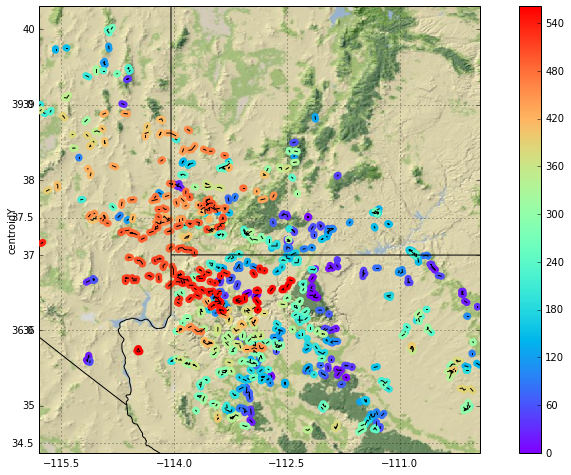

In [7]:
feature_locations(ft.titanize(), paths=True)

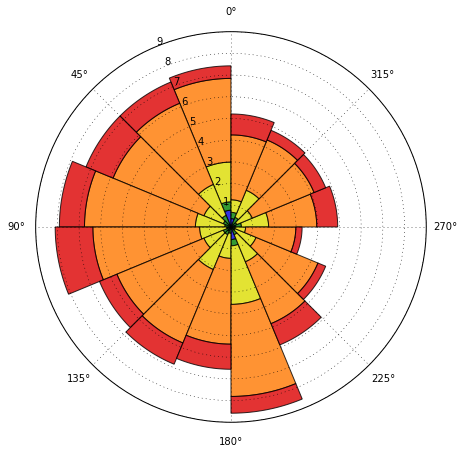

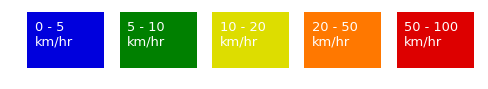

In [8]:
plt.figure(figsize=(7,7))
ft.windrose();

This method of animating creates really big files, but they are fully html, so you can easily save them as part of a notebook. I don't recommend it generally, but just to get a sense of what is going on it can be useful.


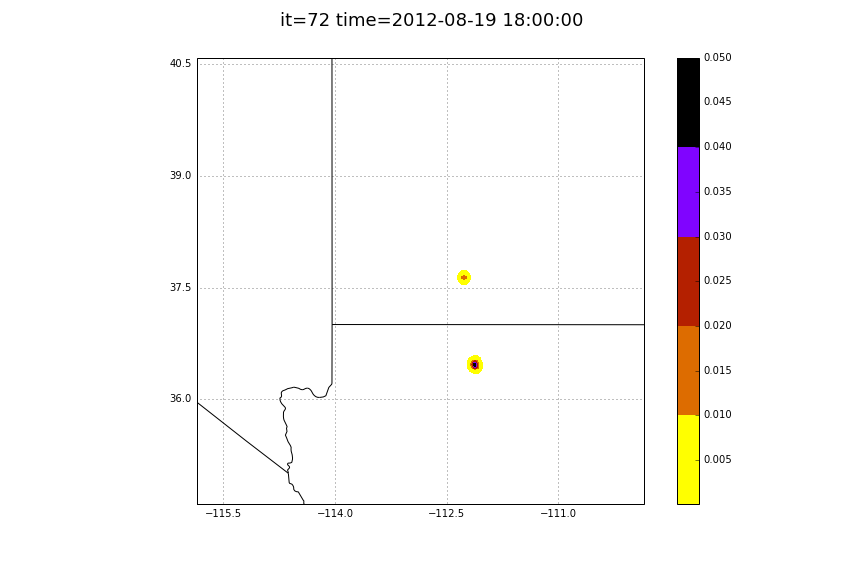
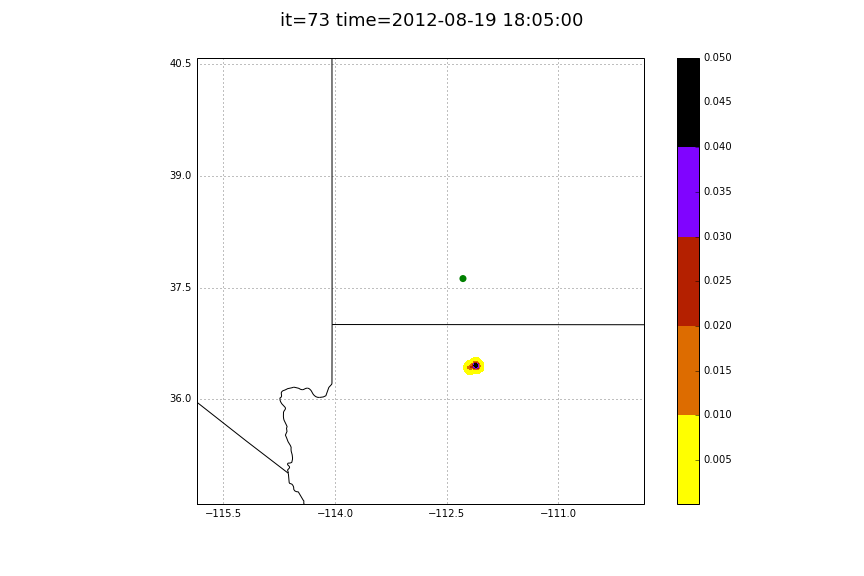
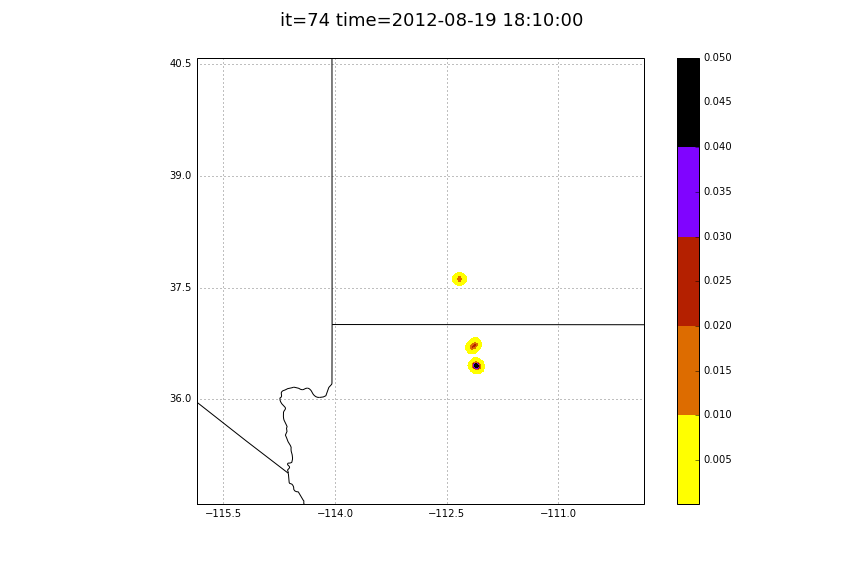
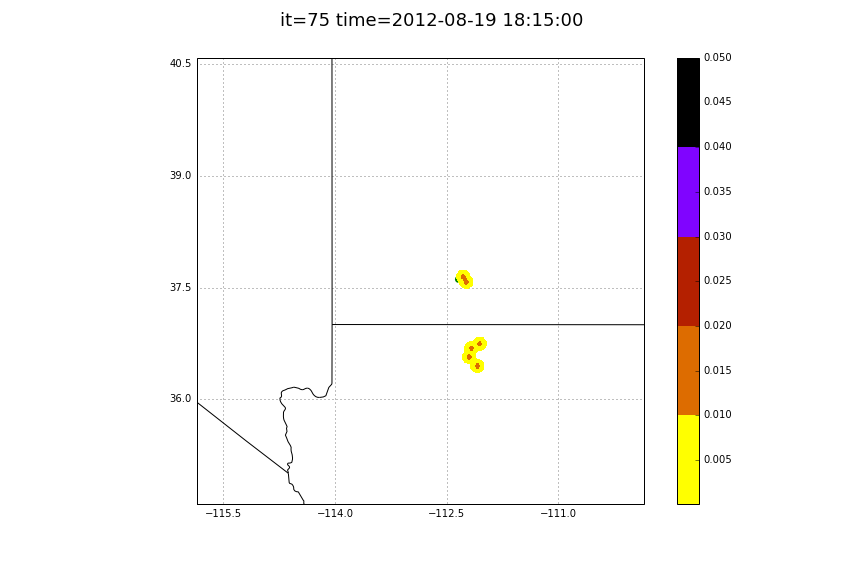
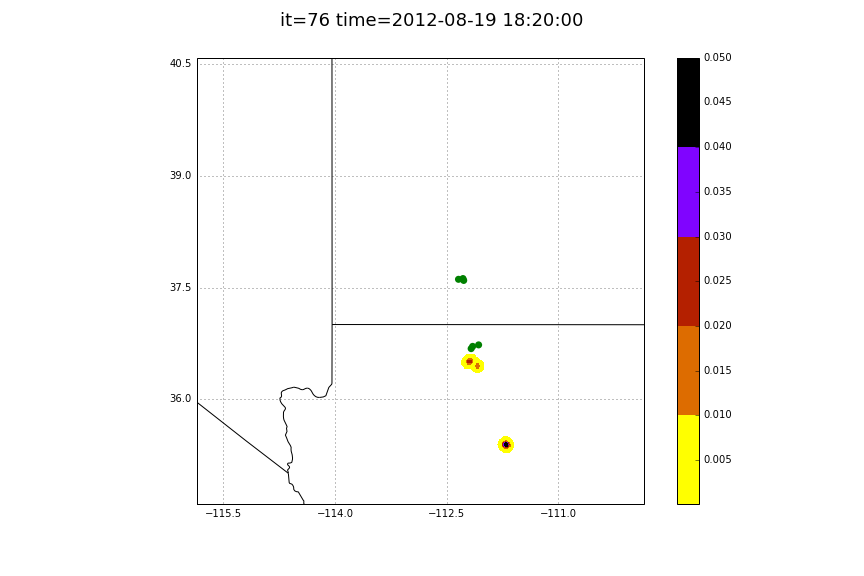
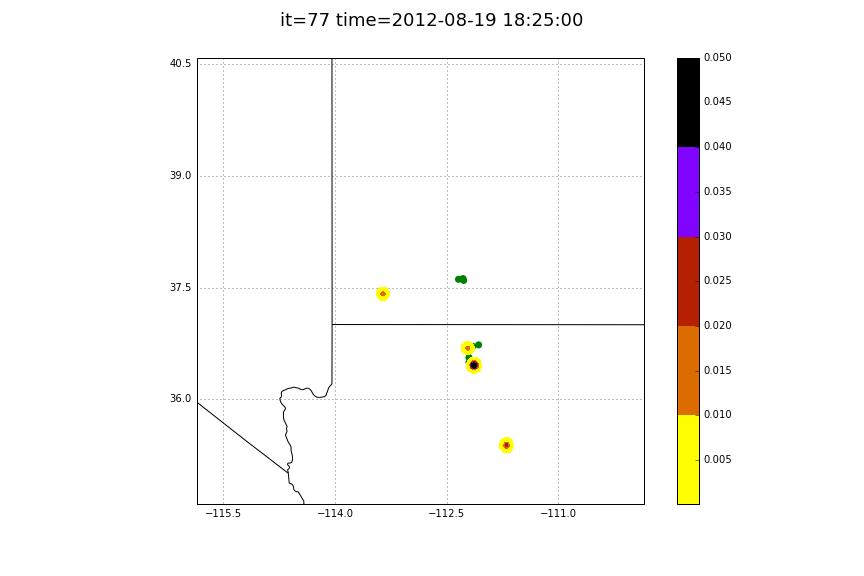
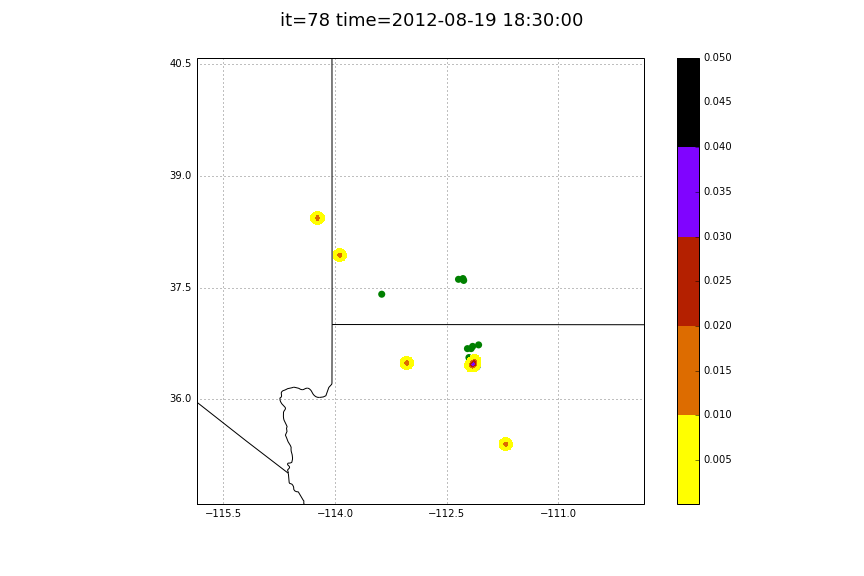
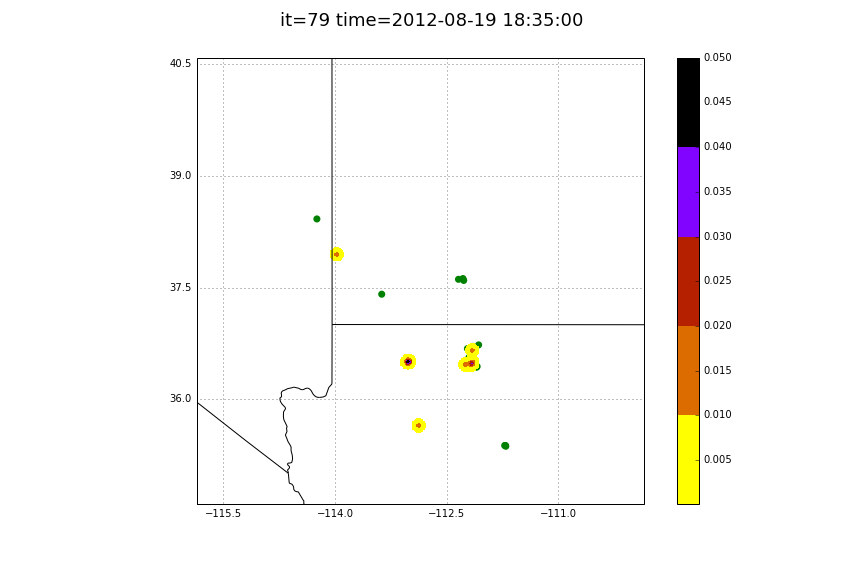
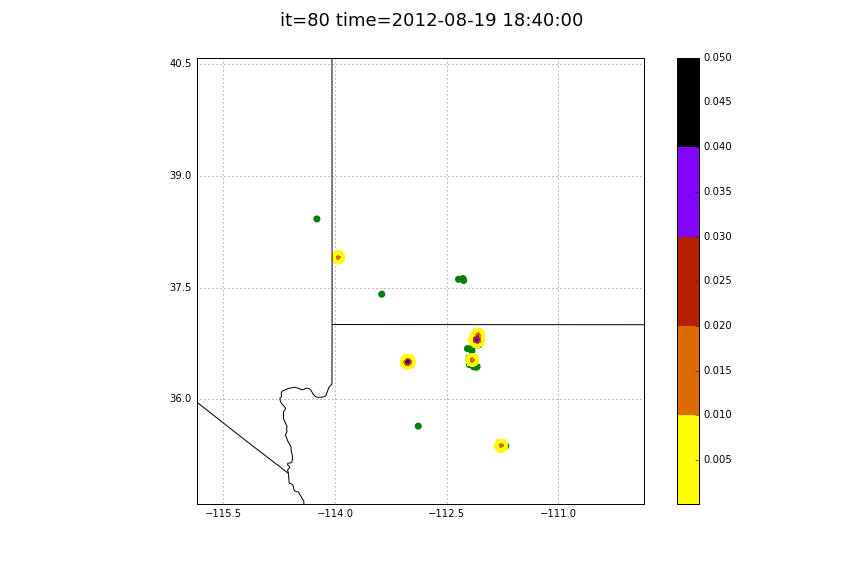
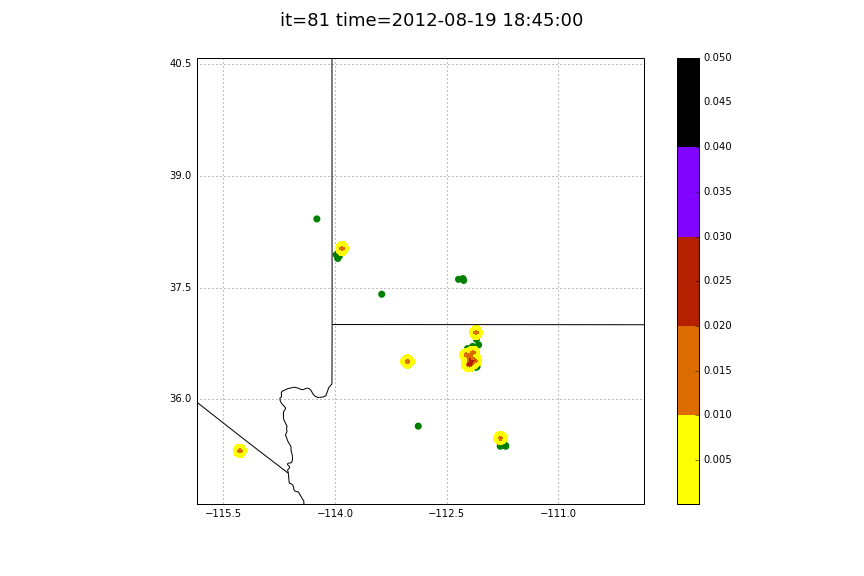
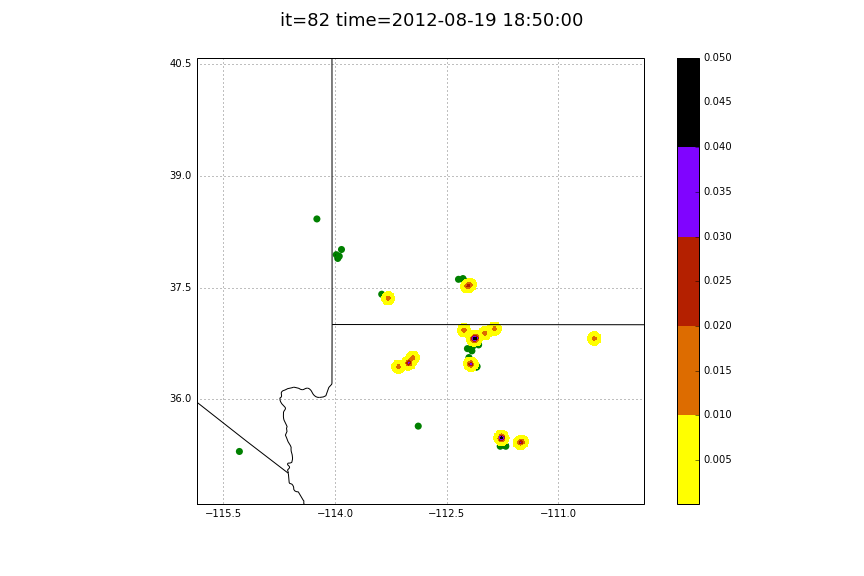
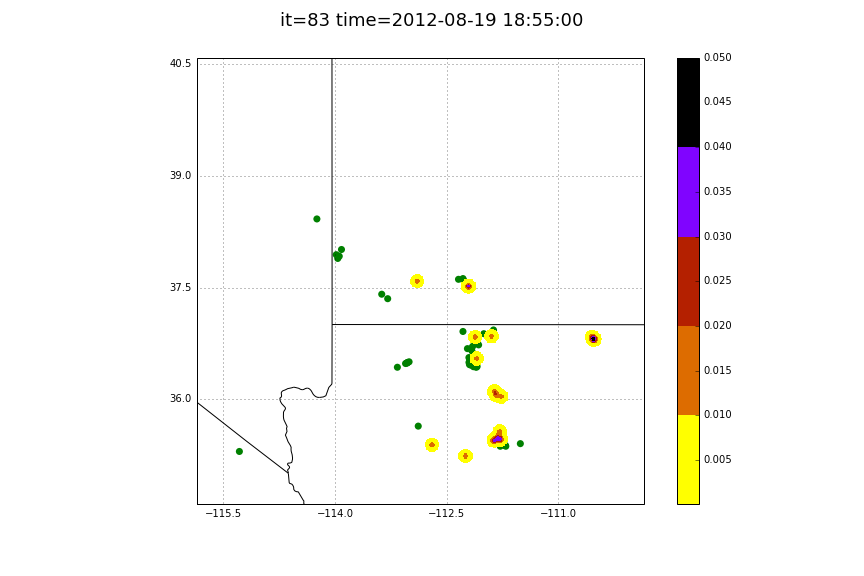
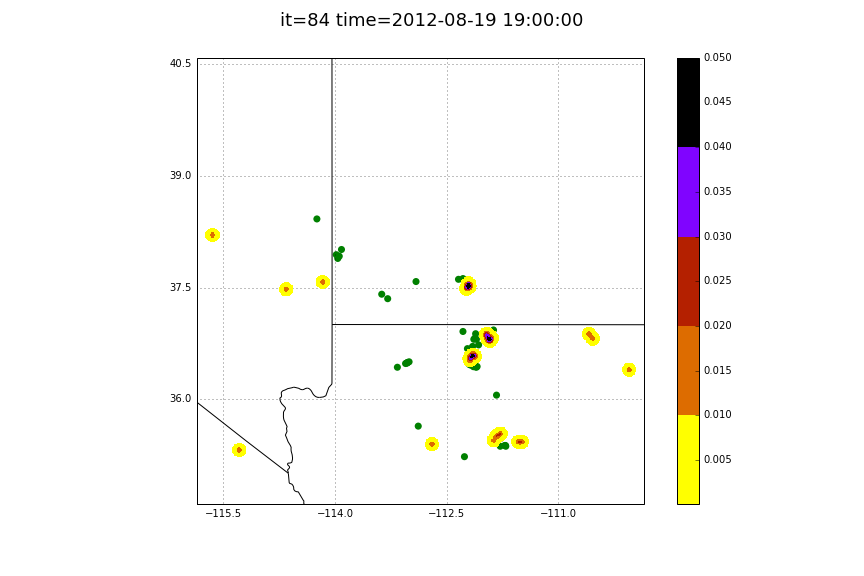
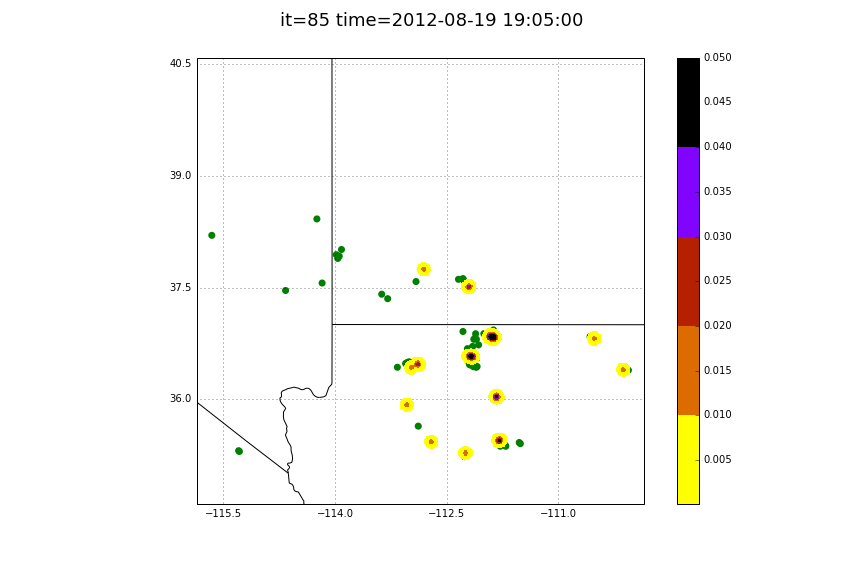
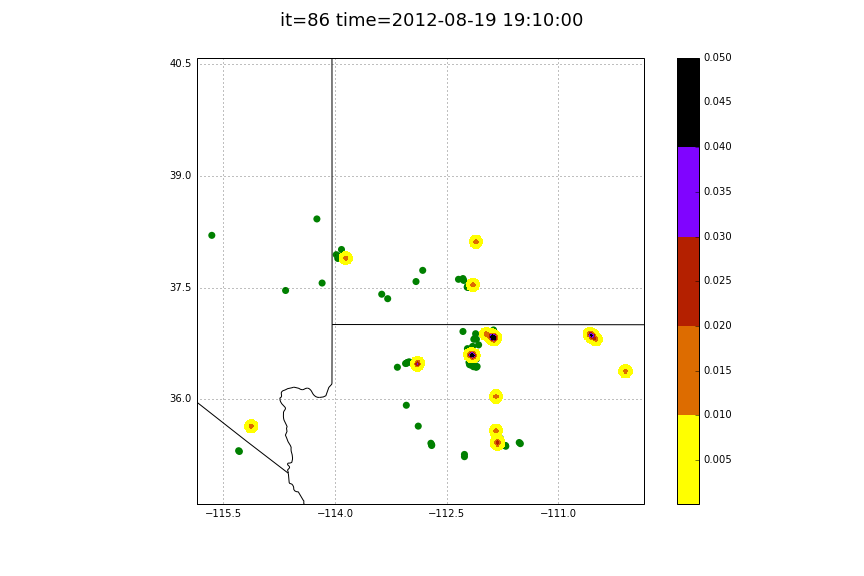
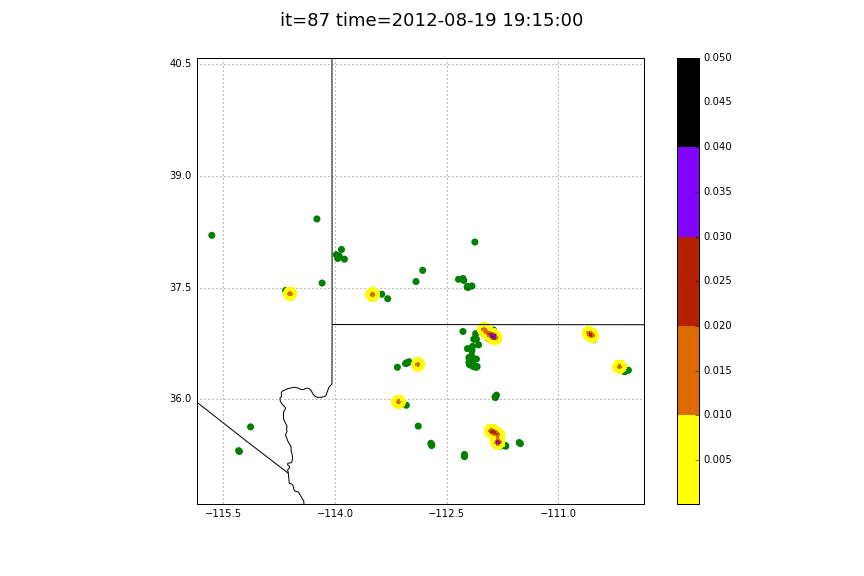
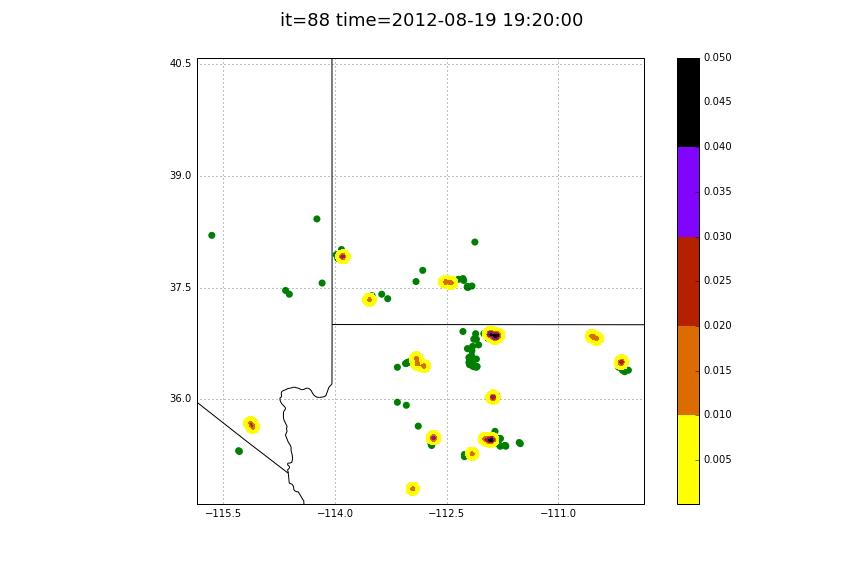
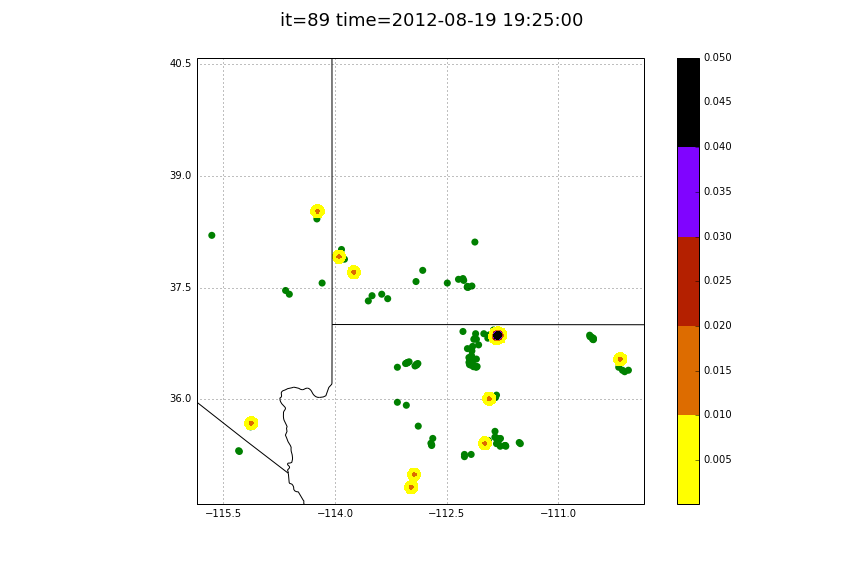
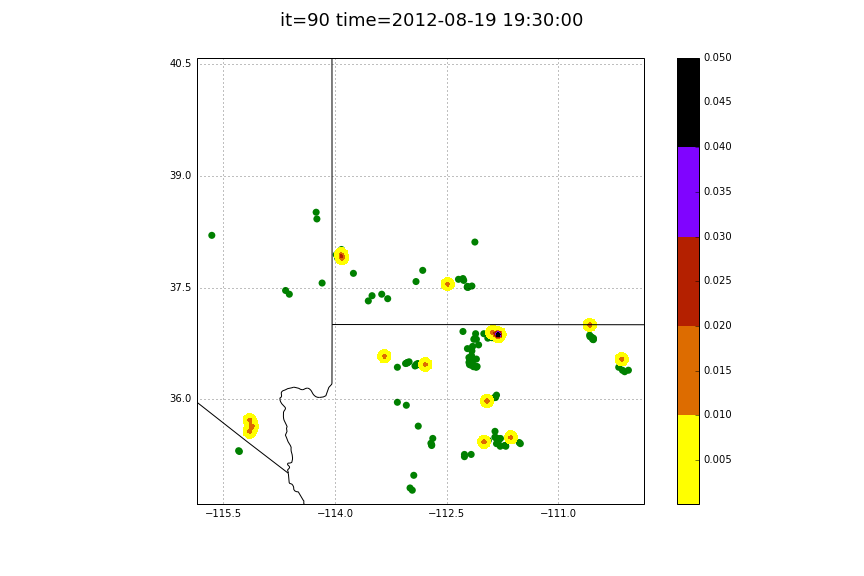
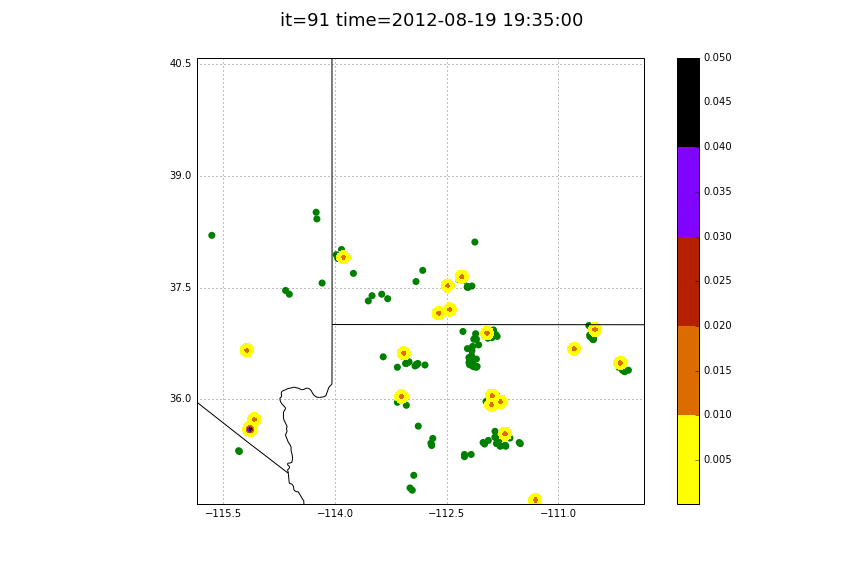
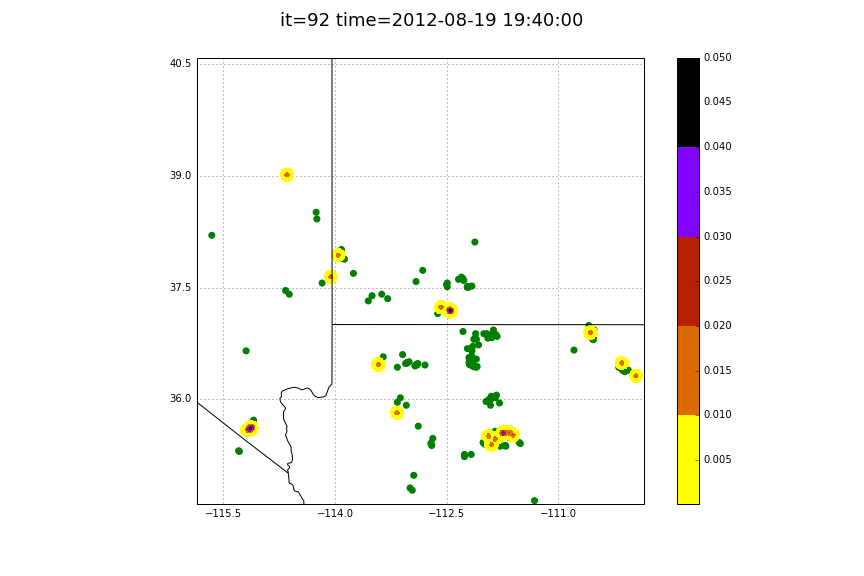
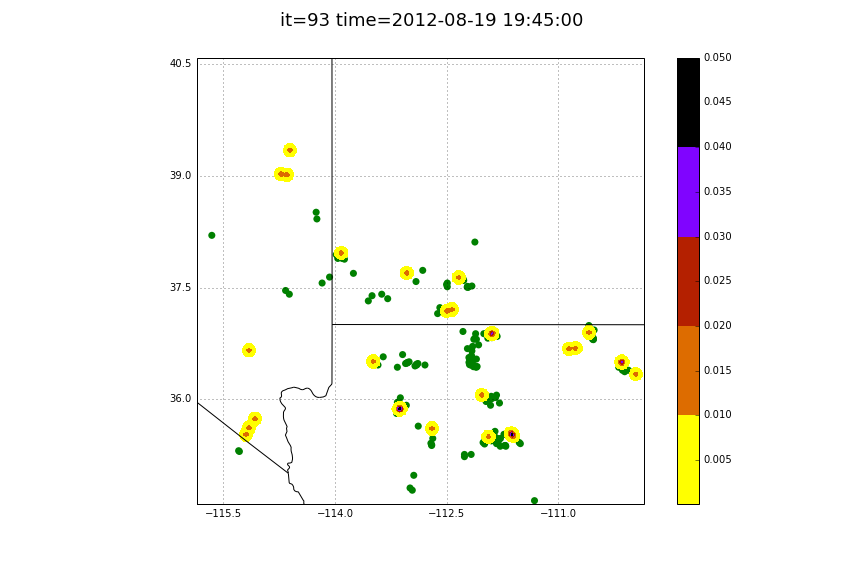
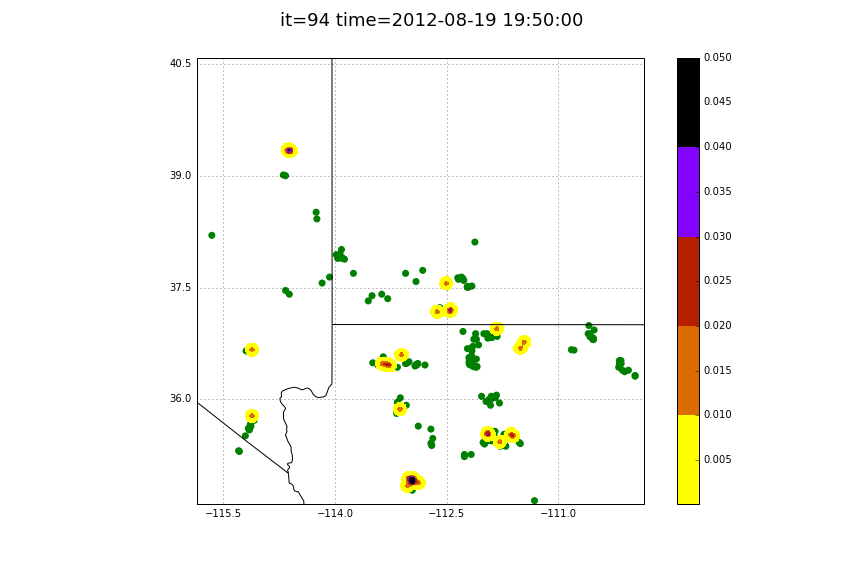
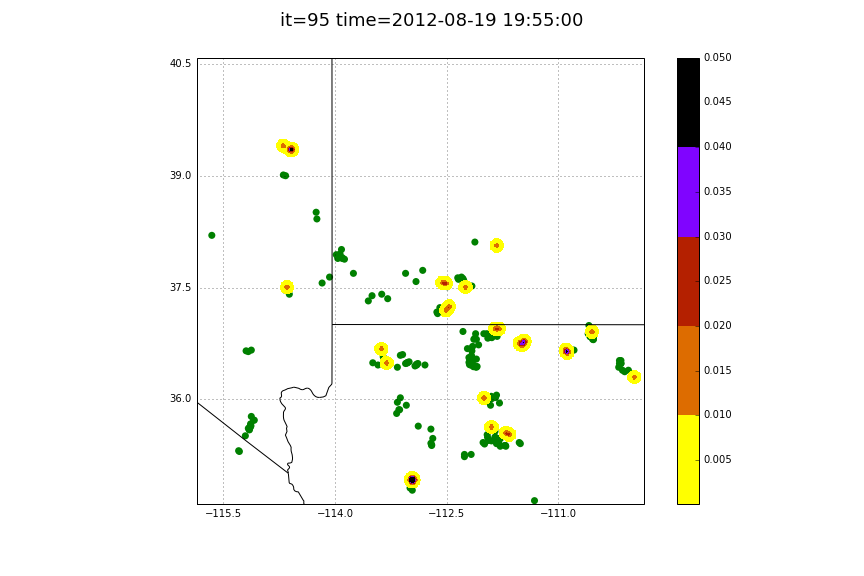
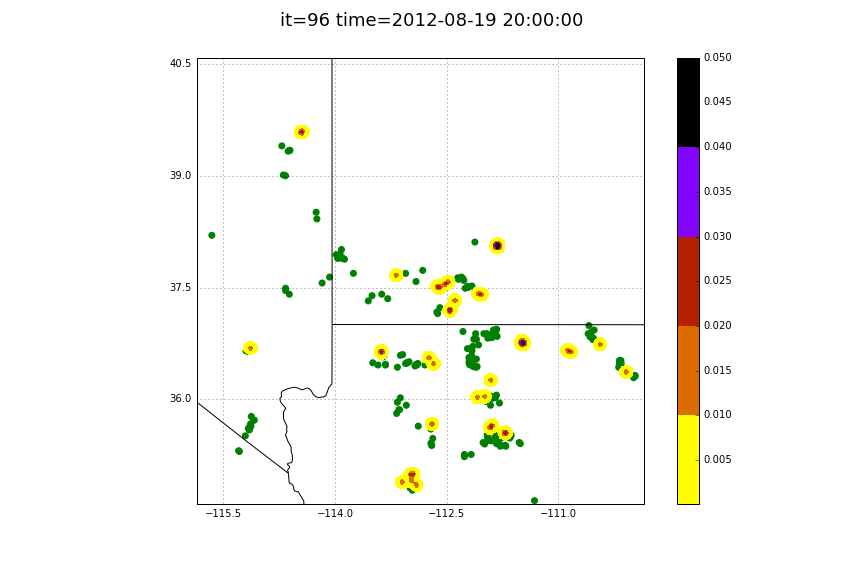
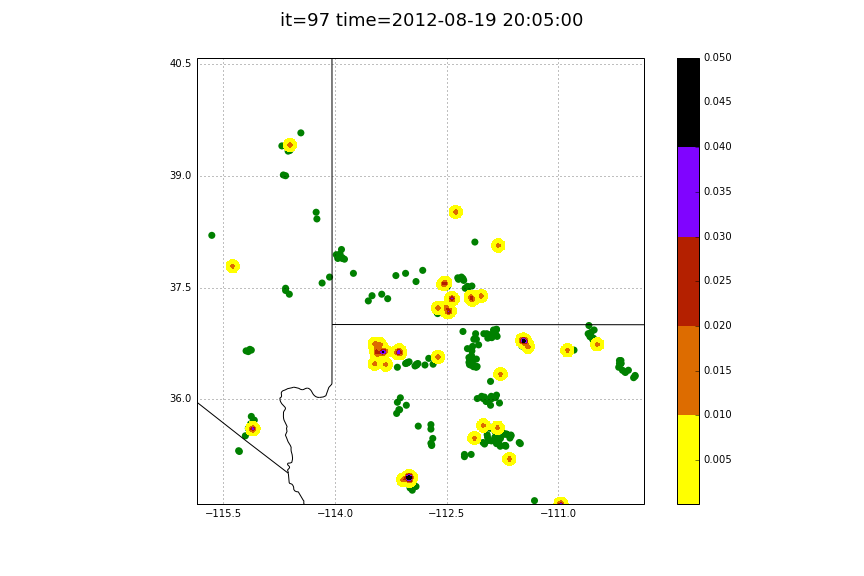
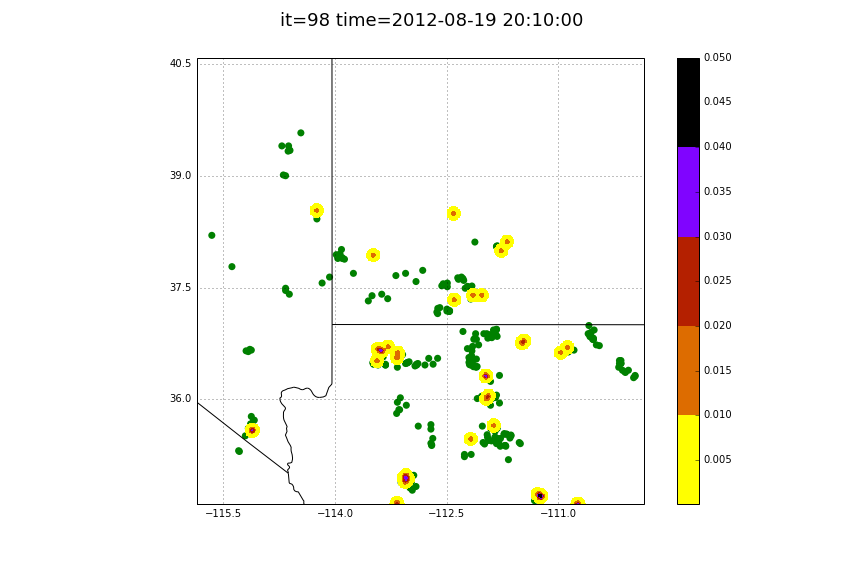
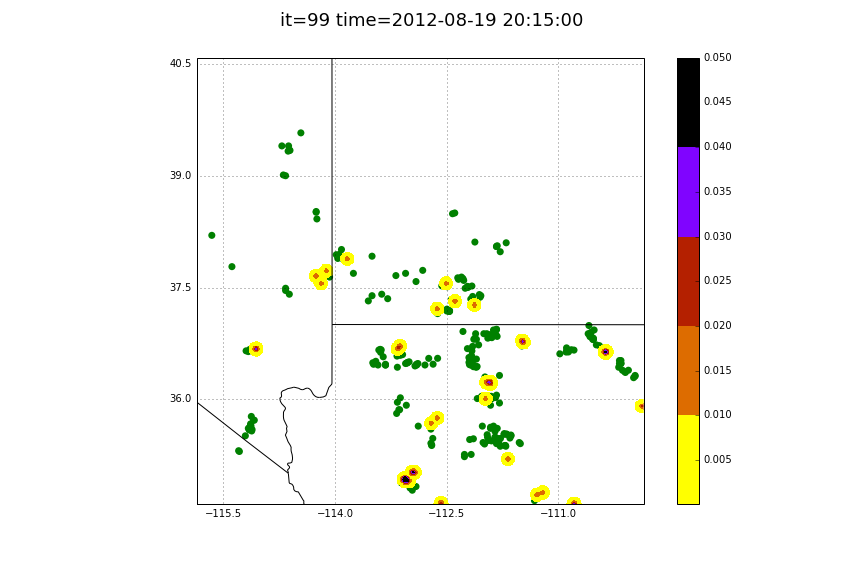
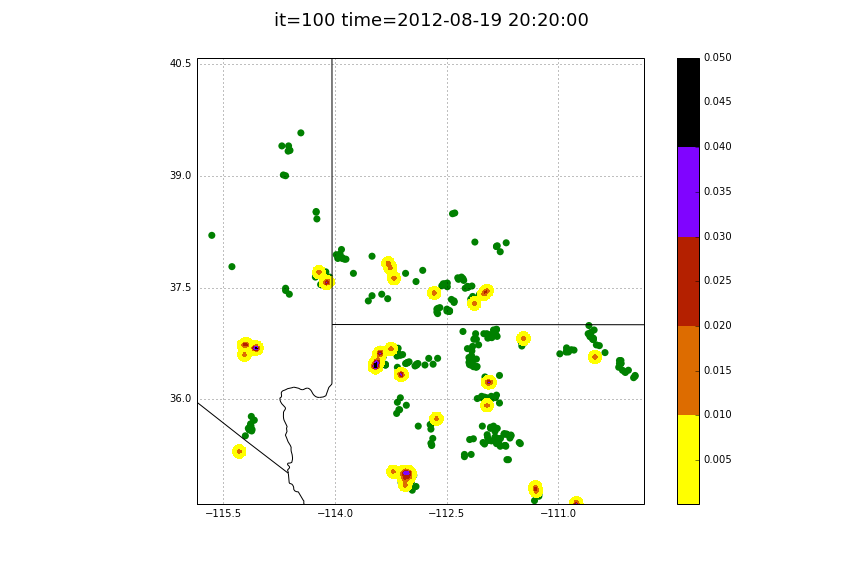
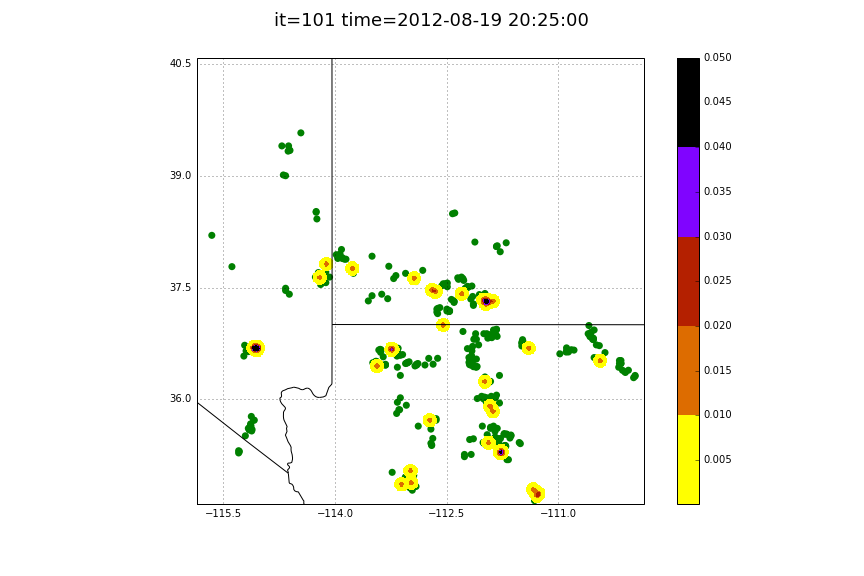
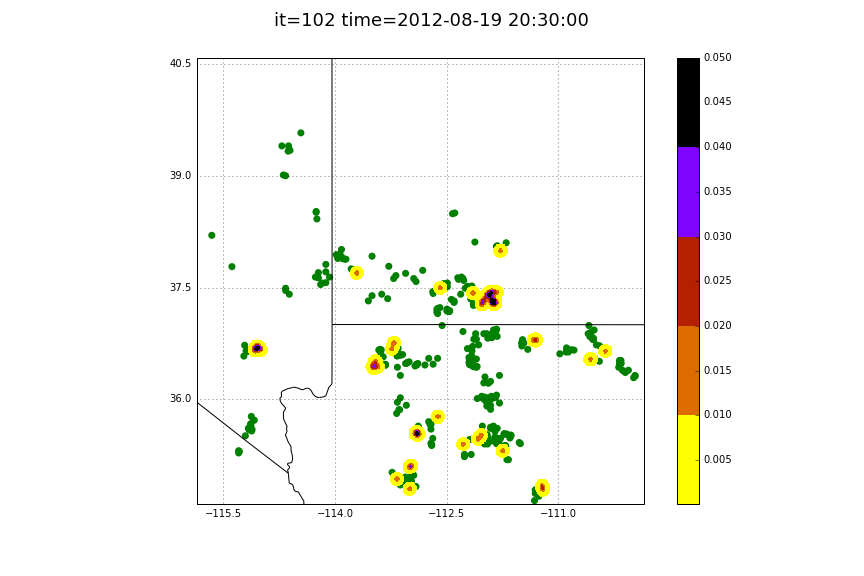
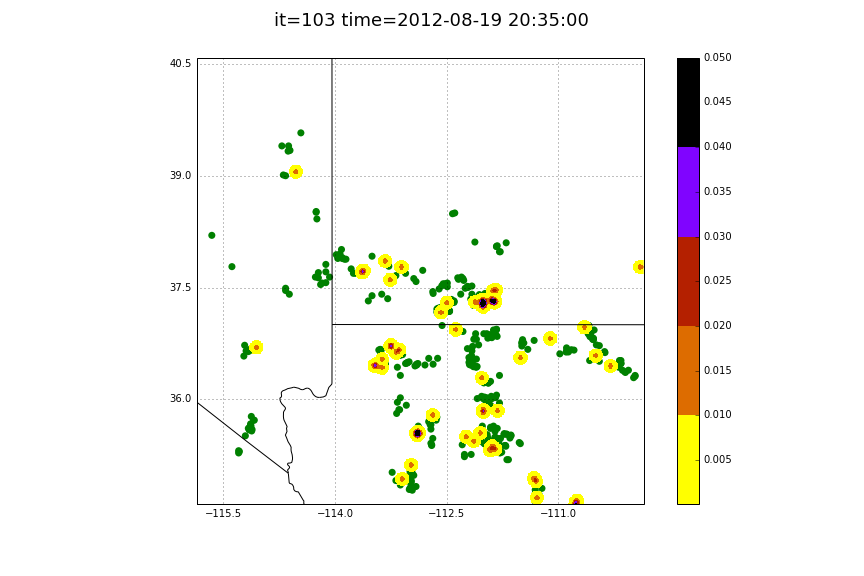
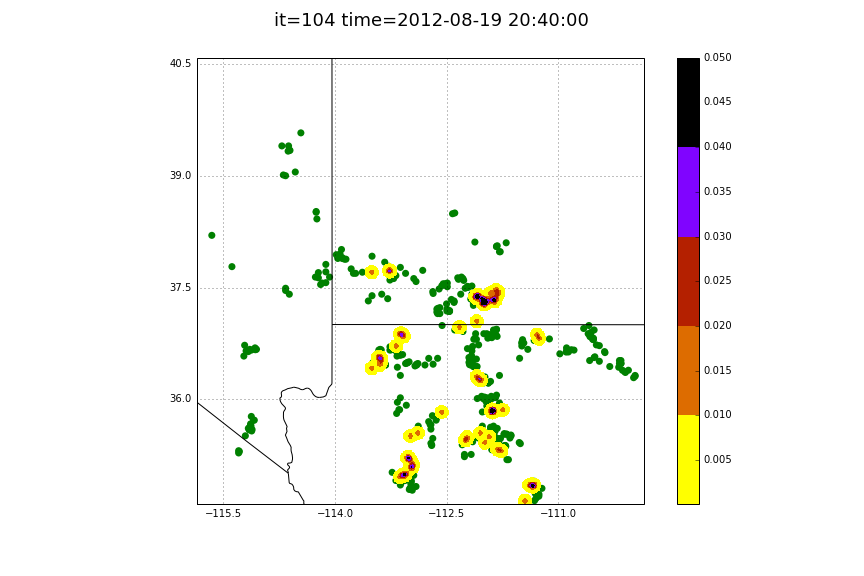
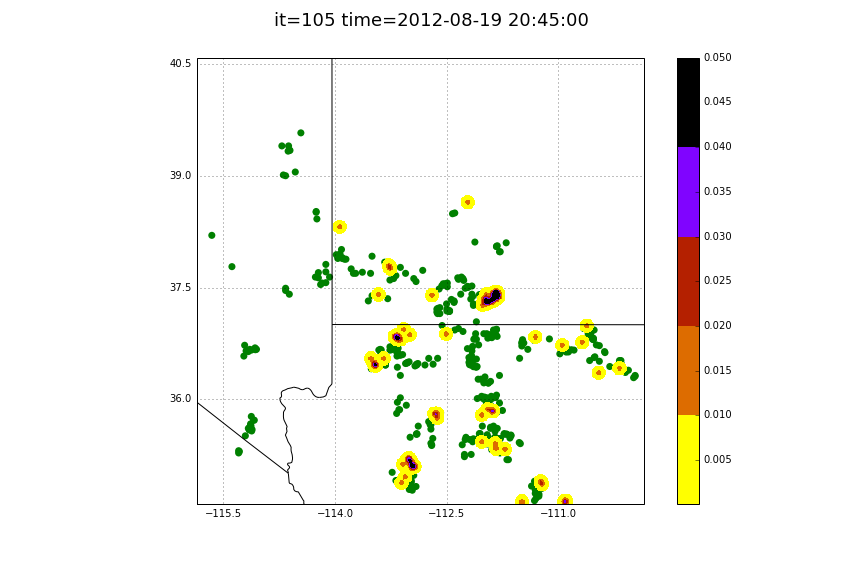
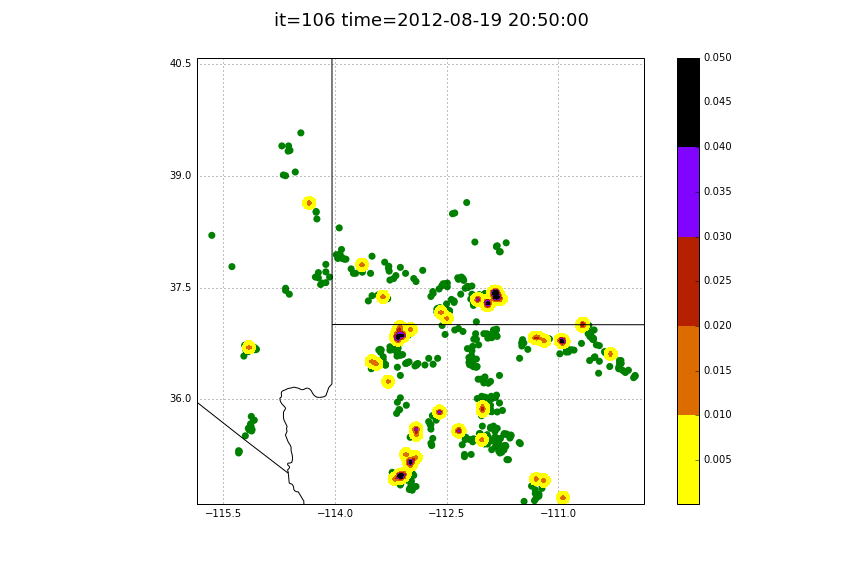
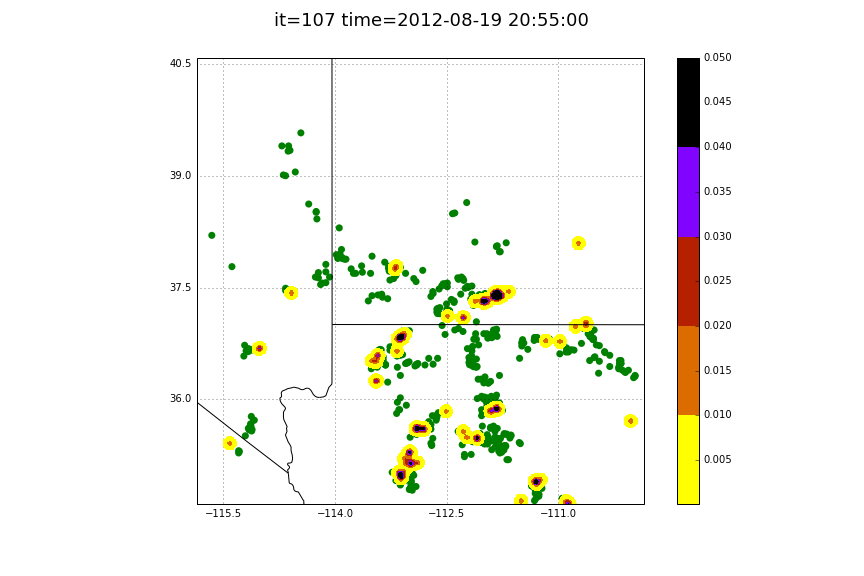
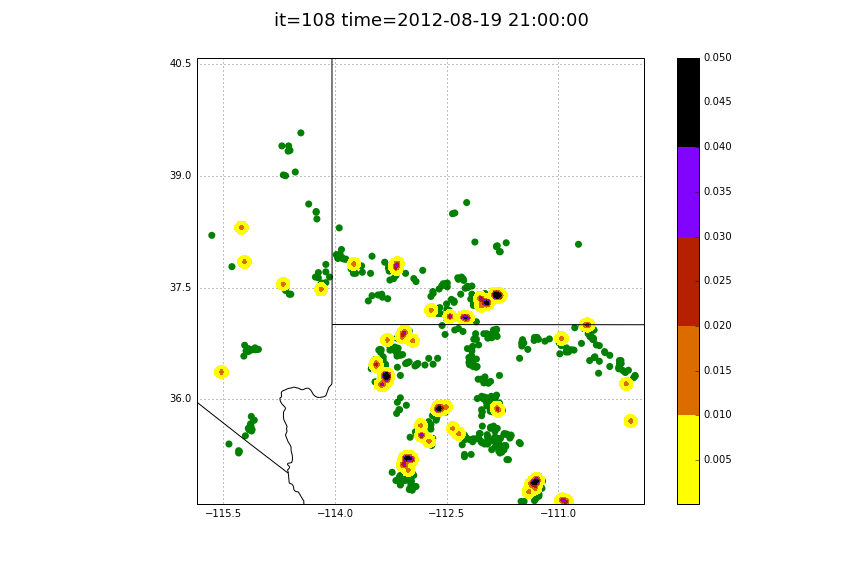
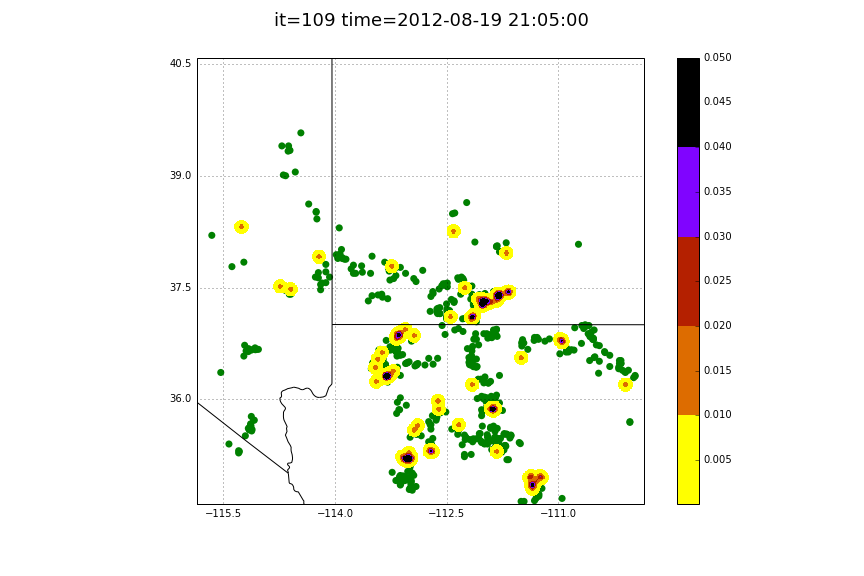
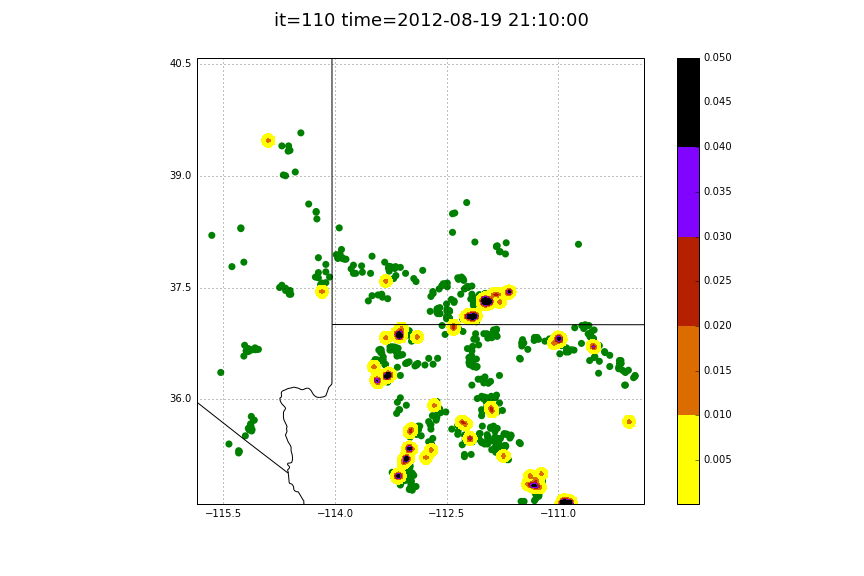
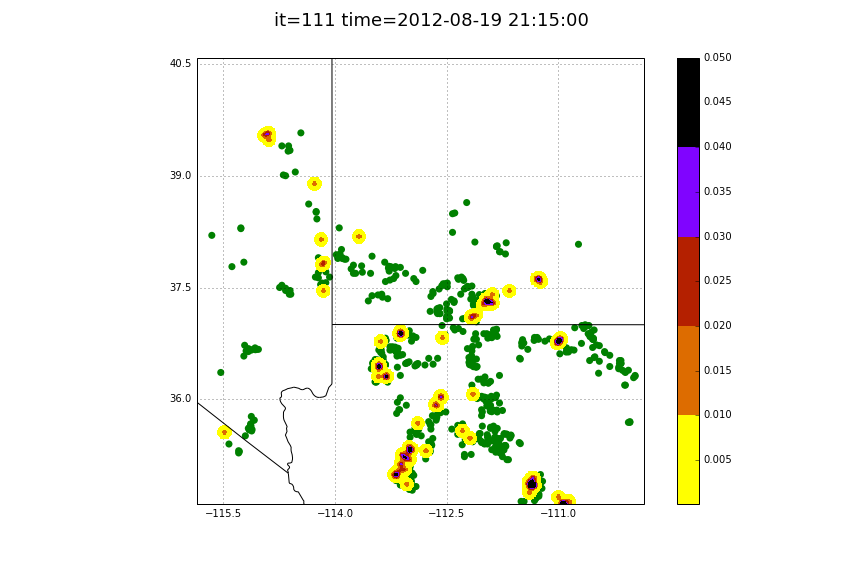
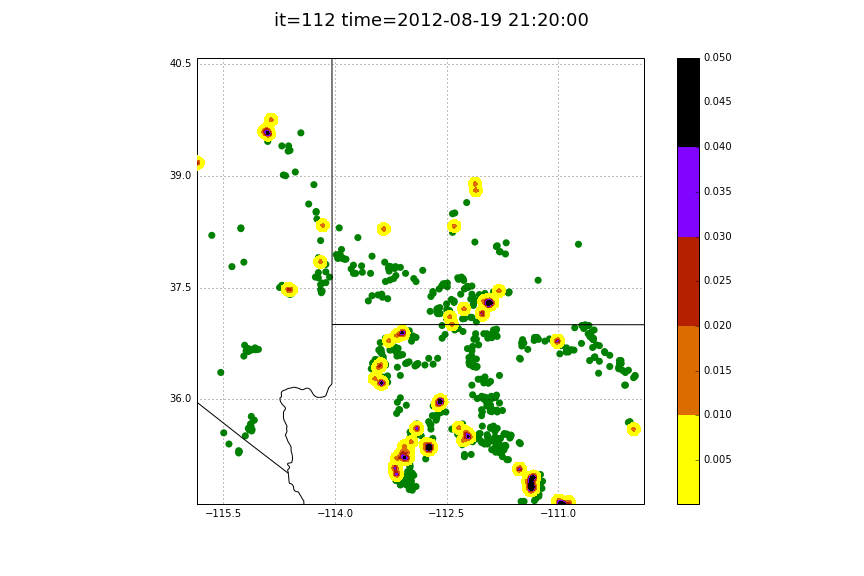
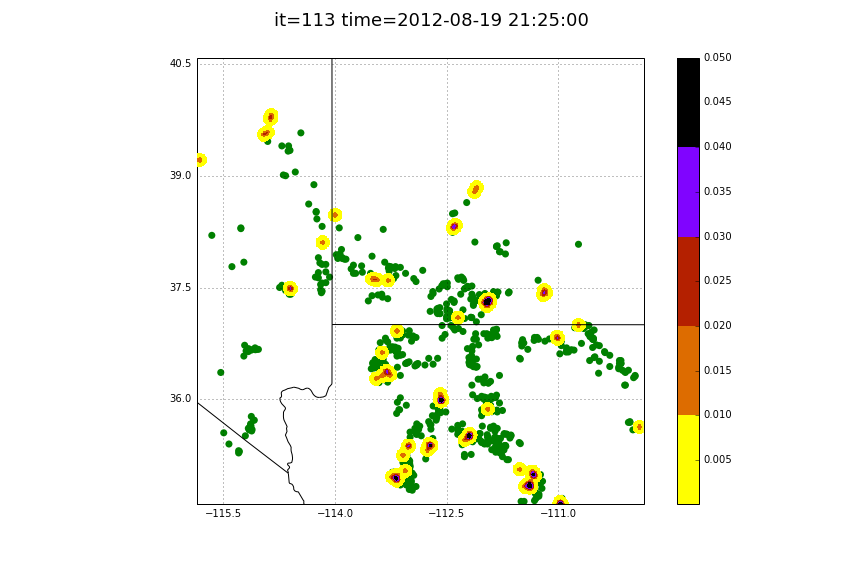
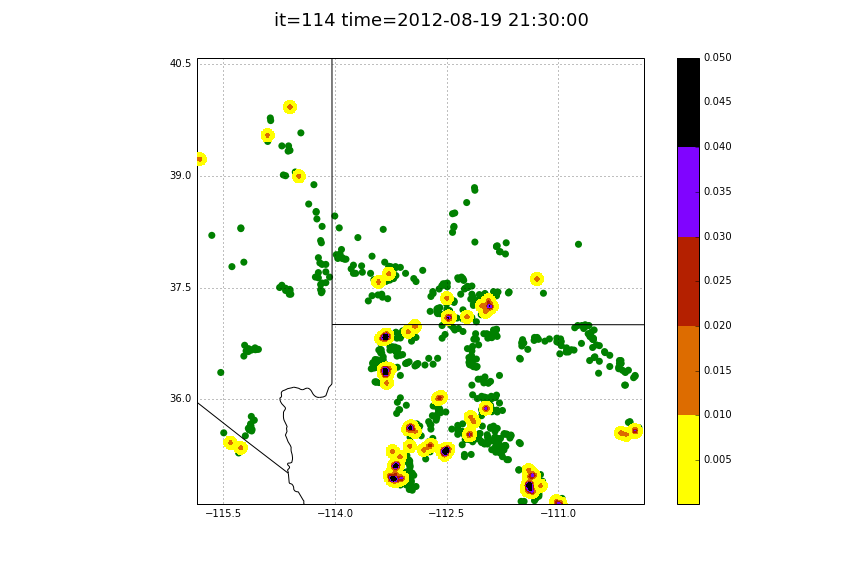
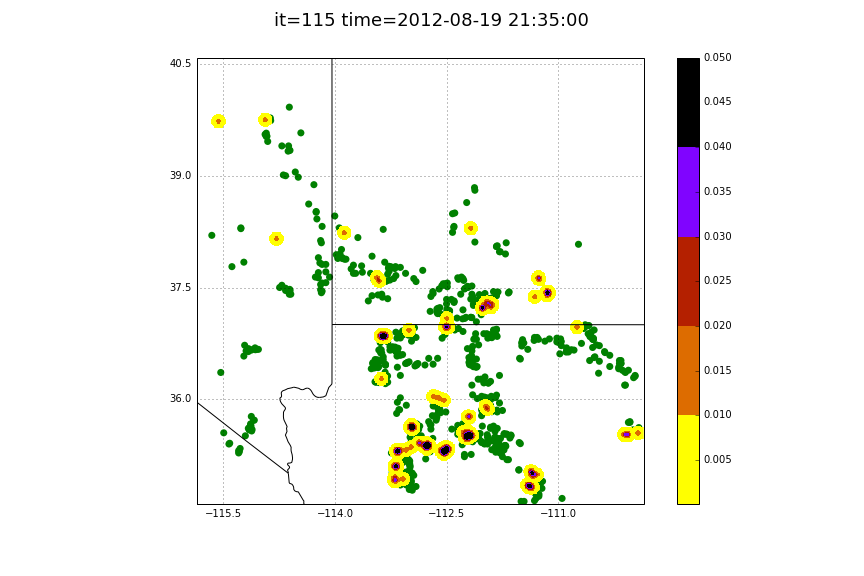
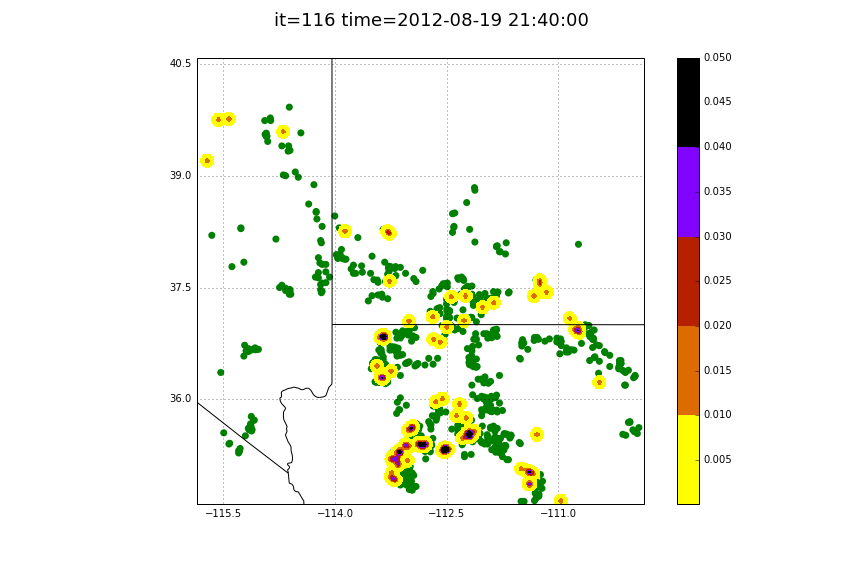
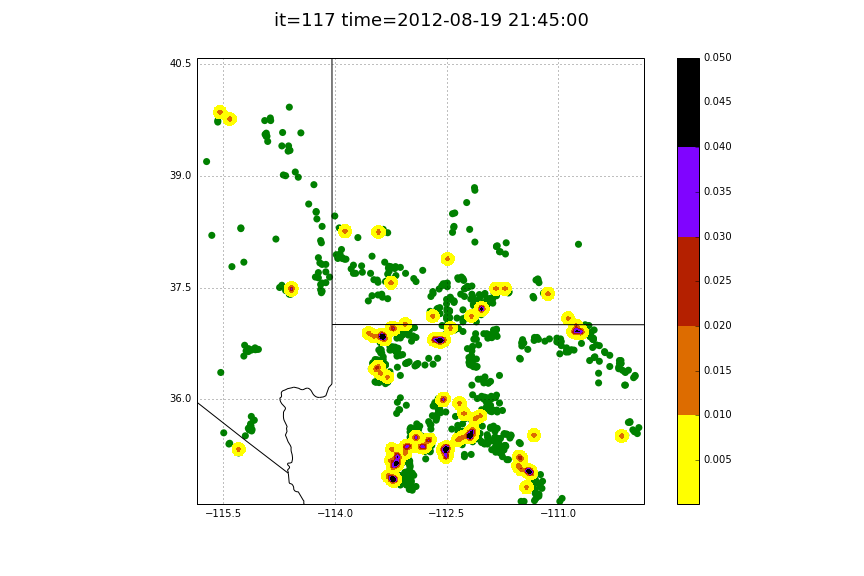
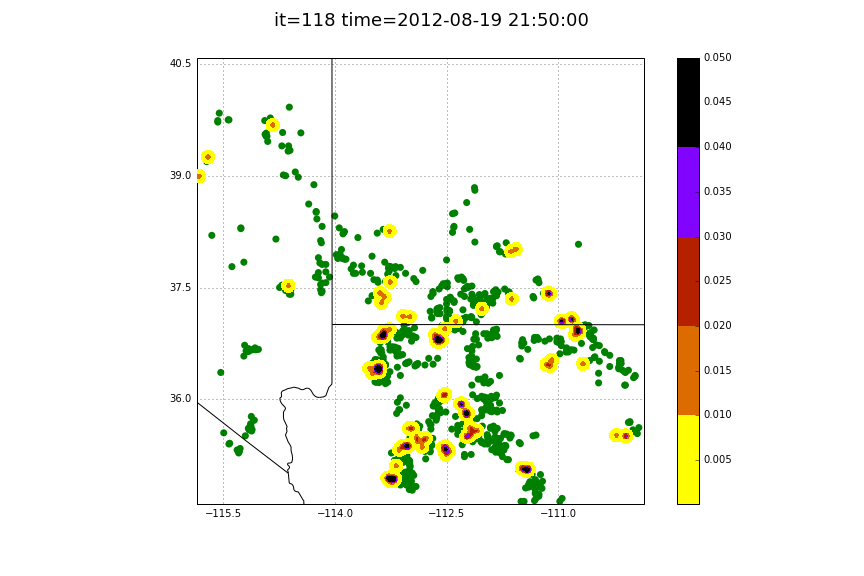
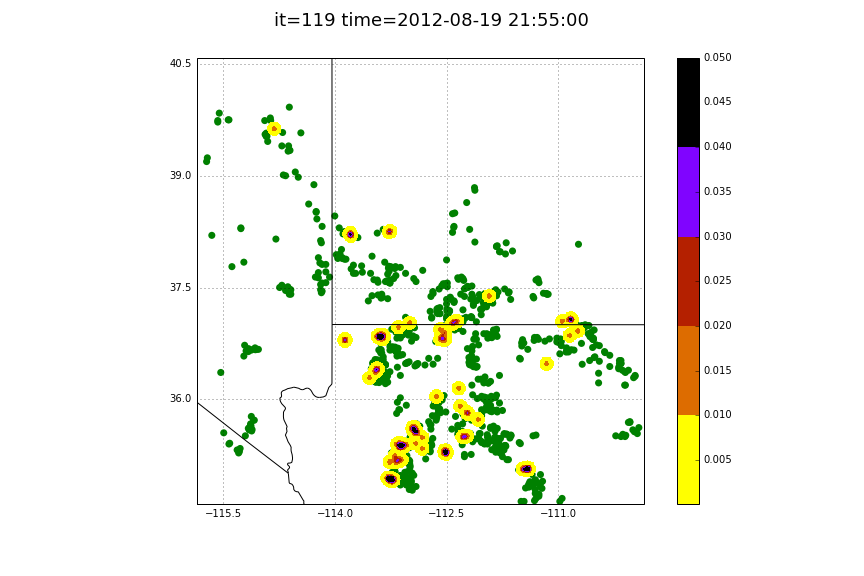
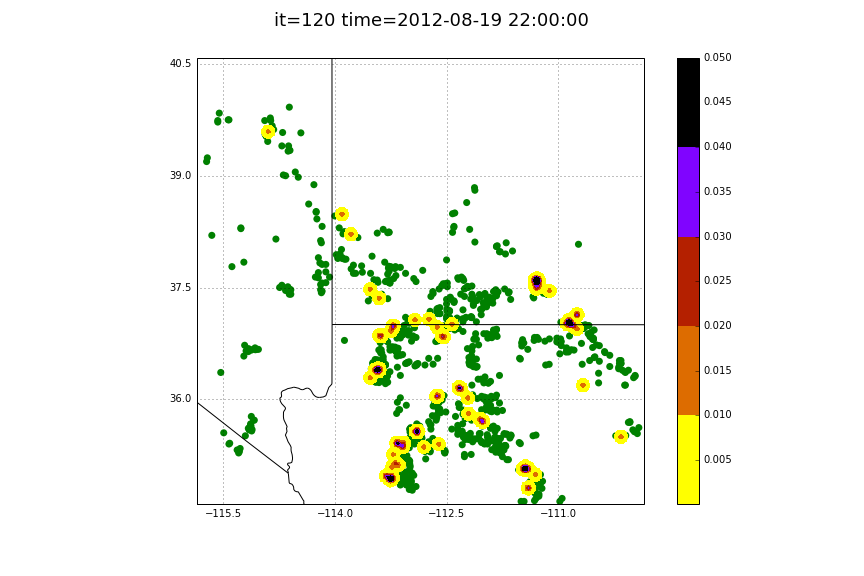
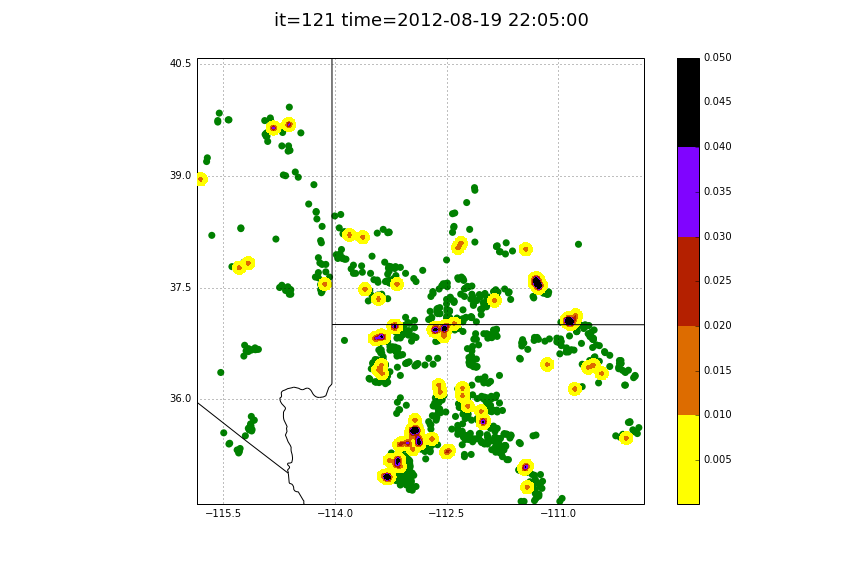
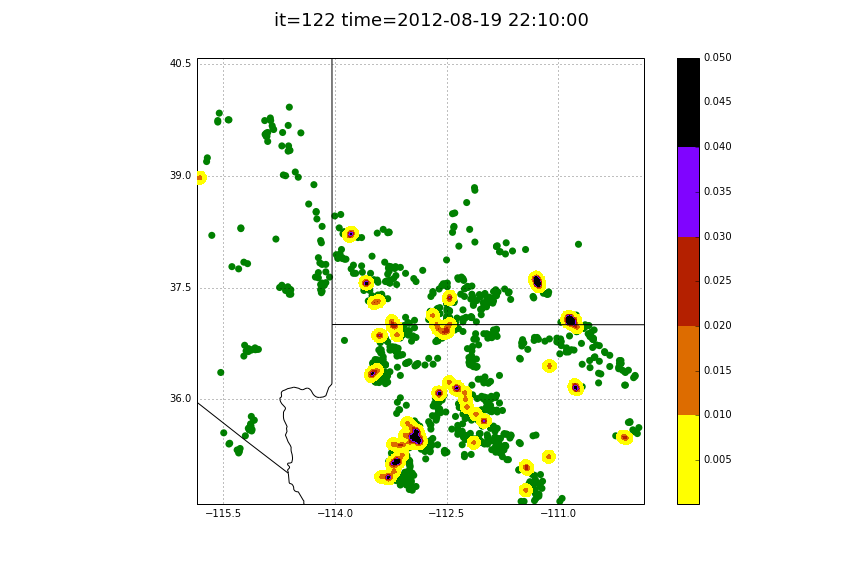
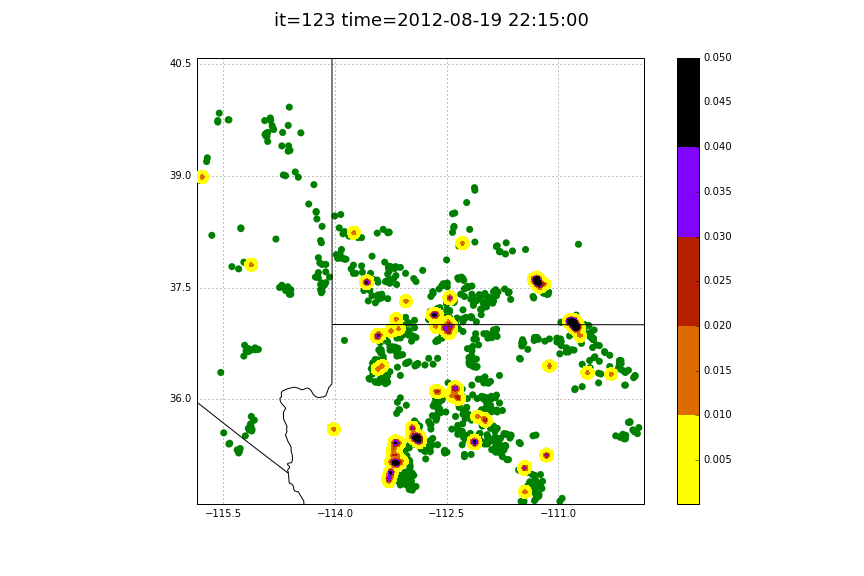
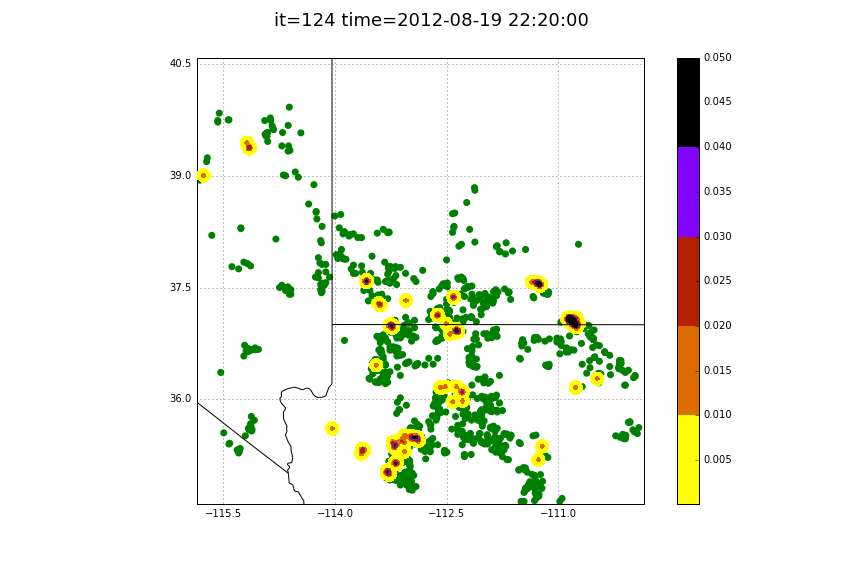
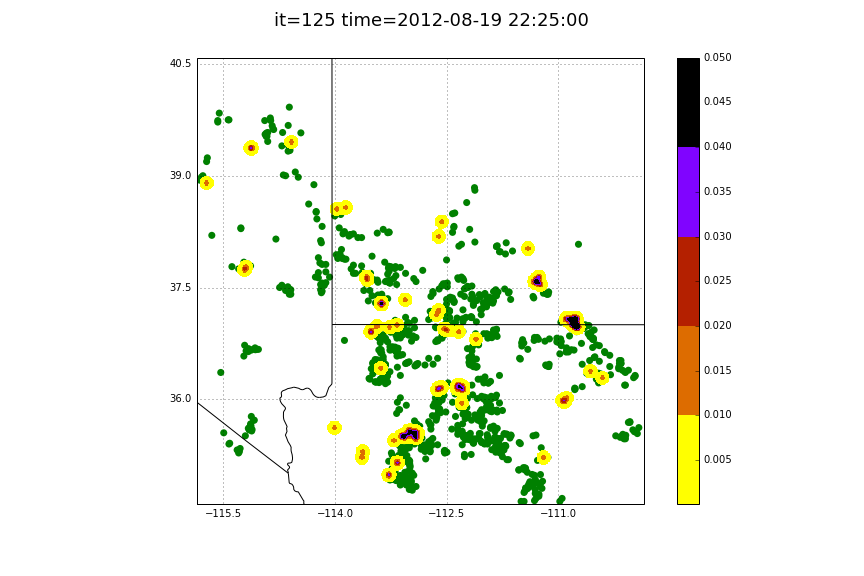
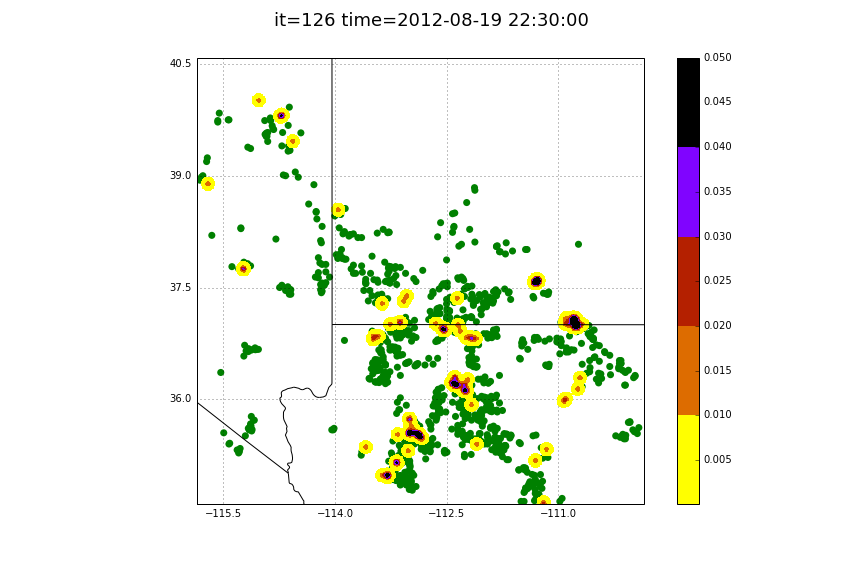
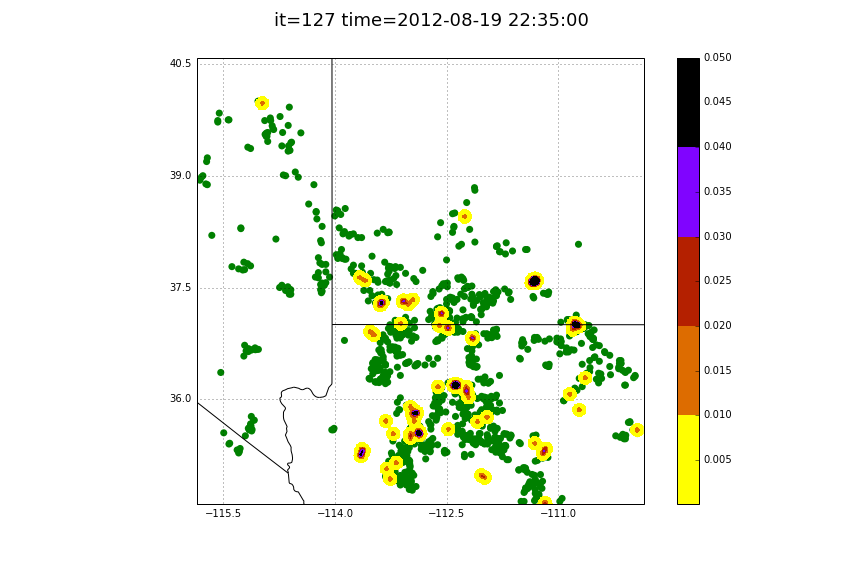
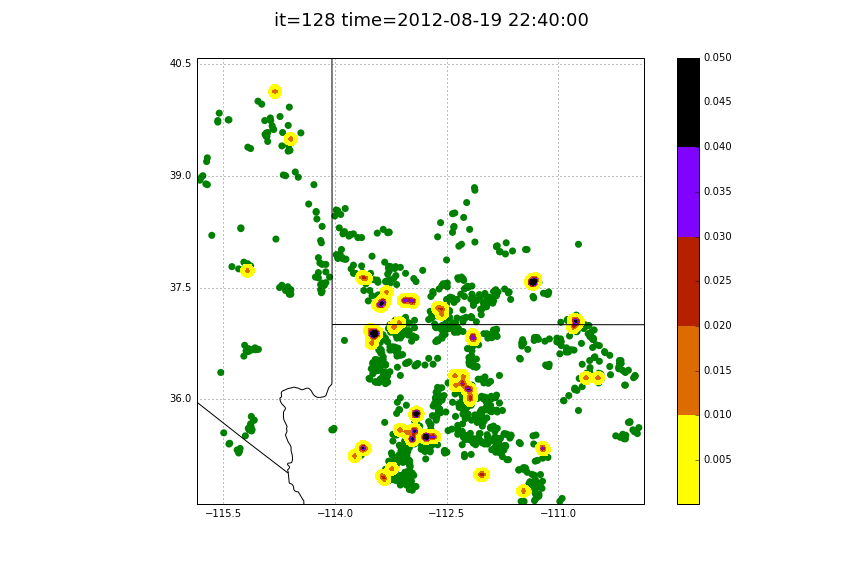
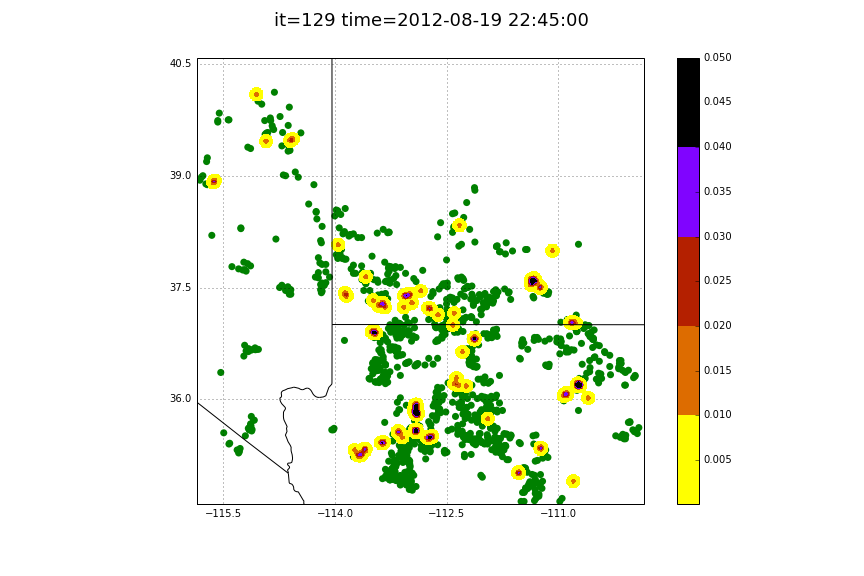
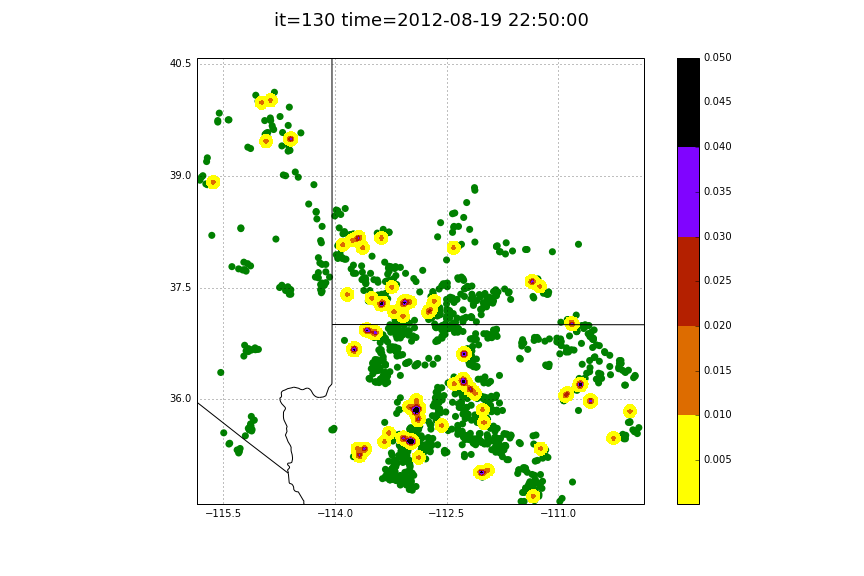
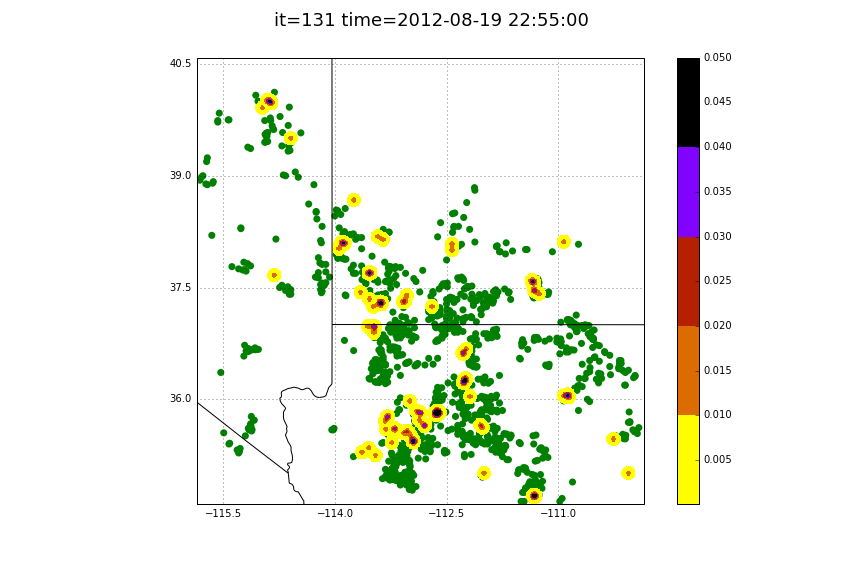
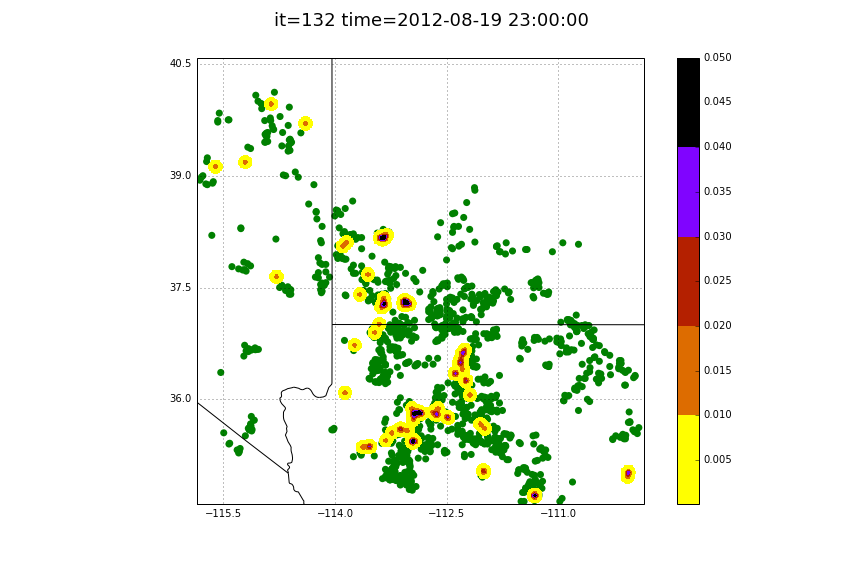
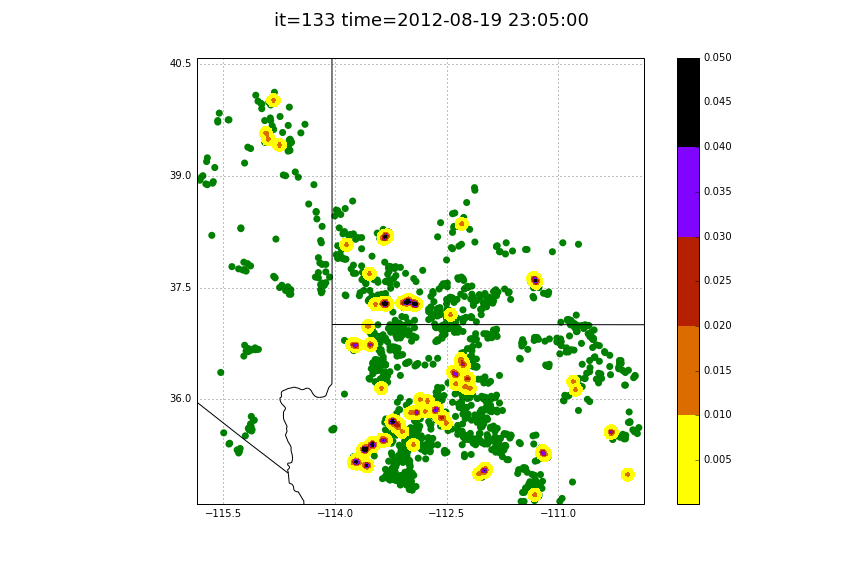
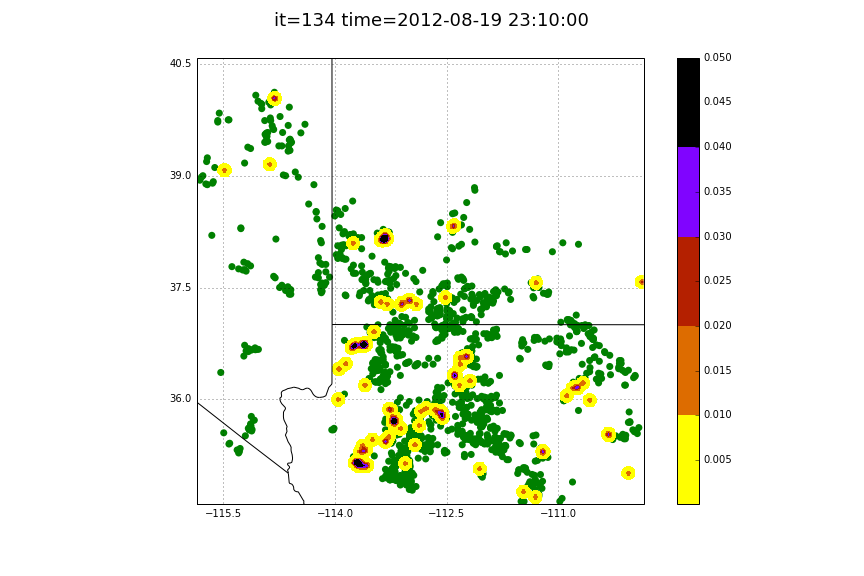
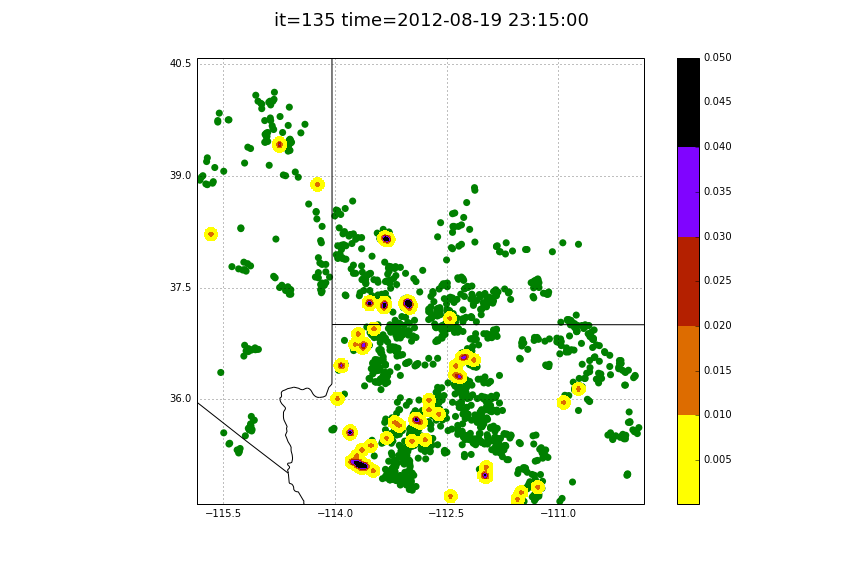
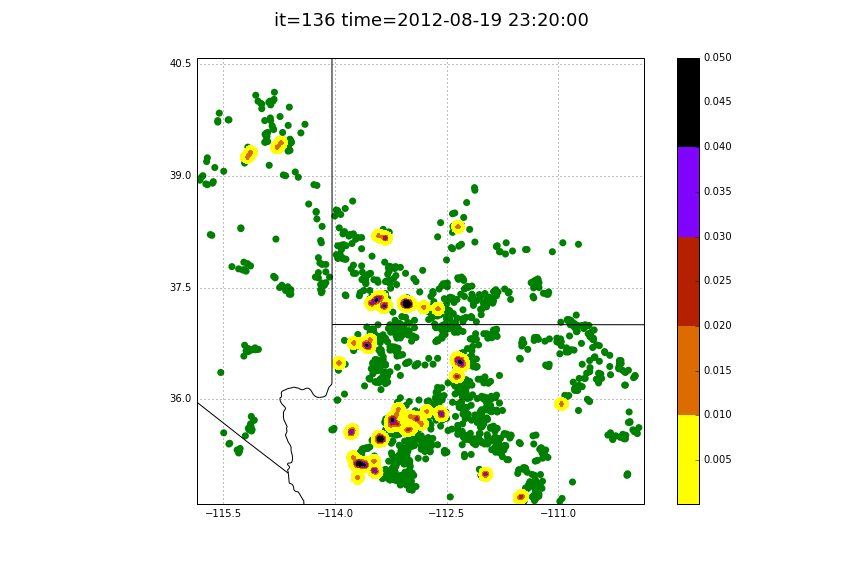
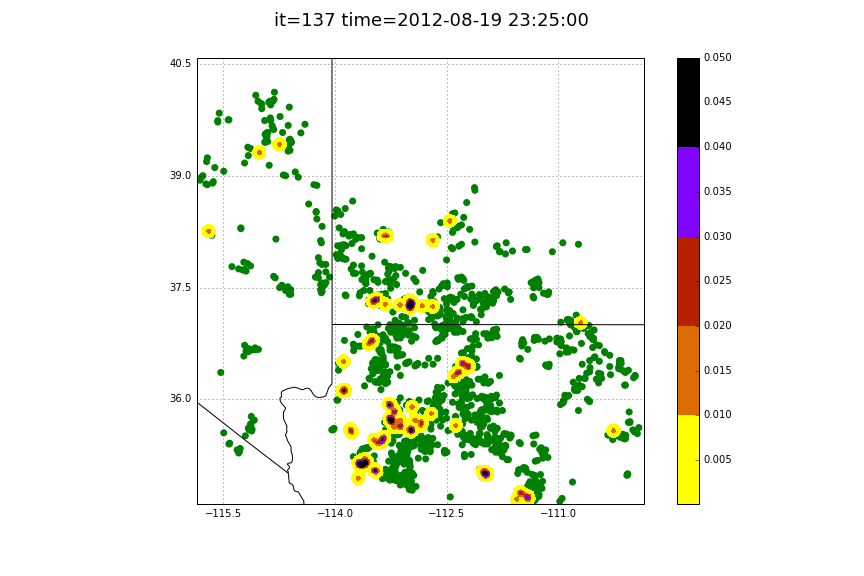
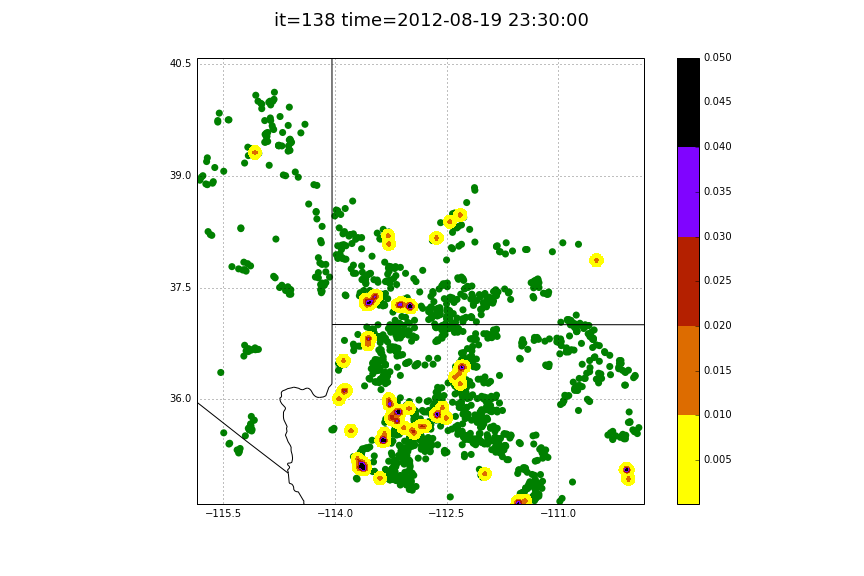
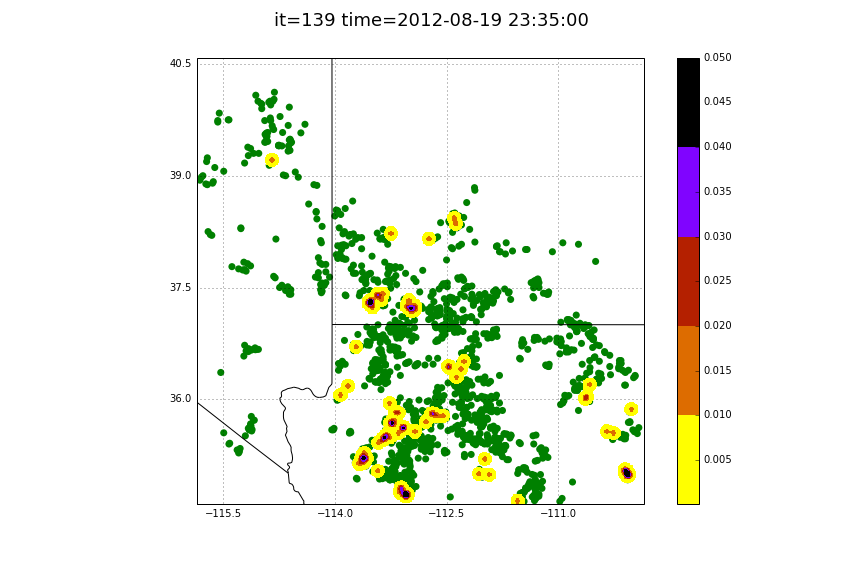
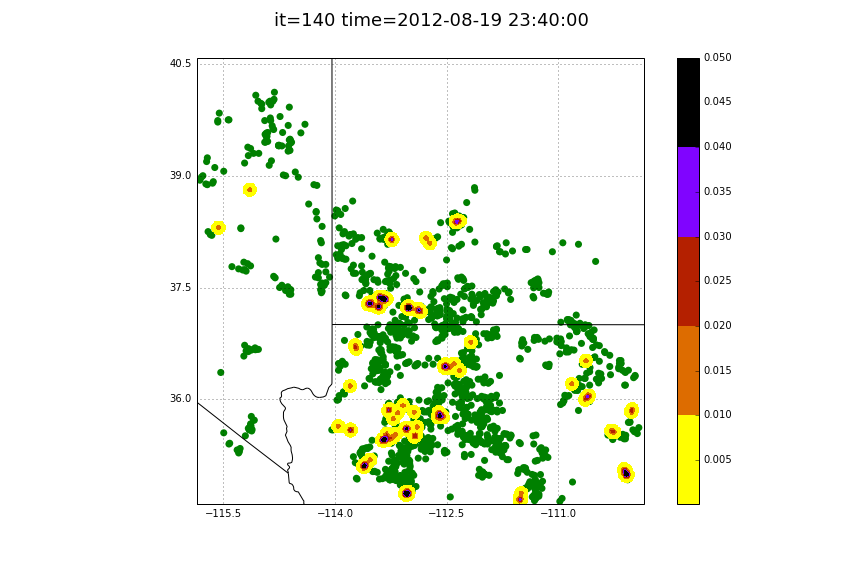
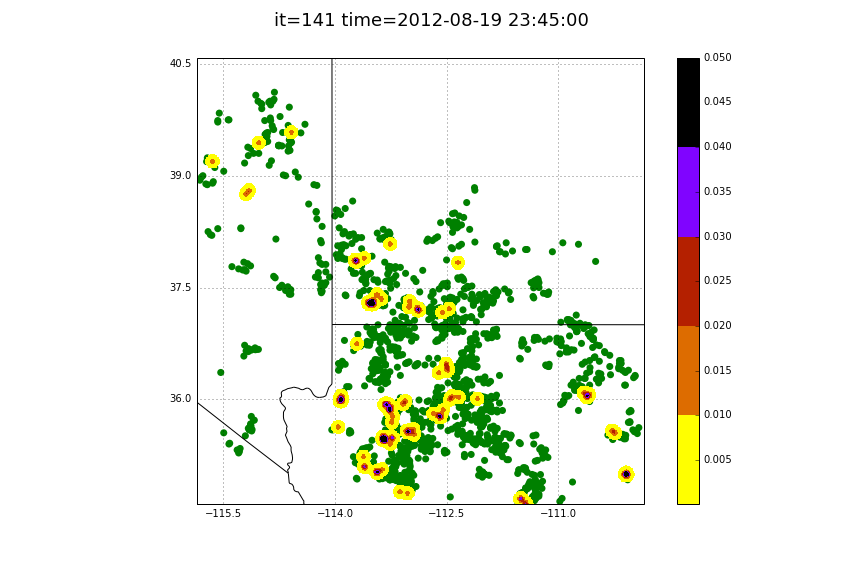
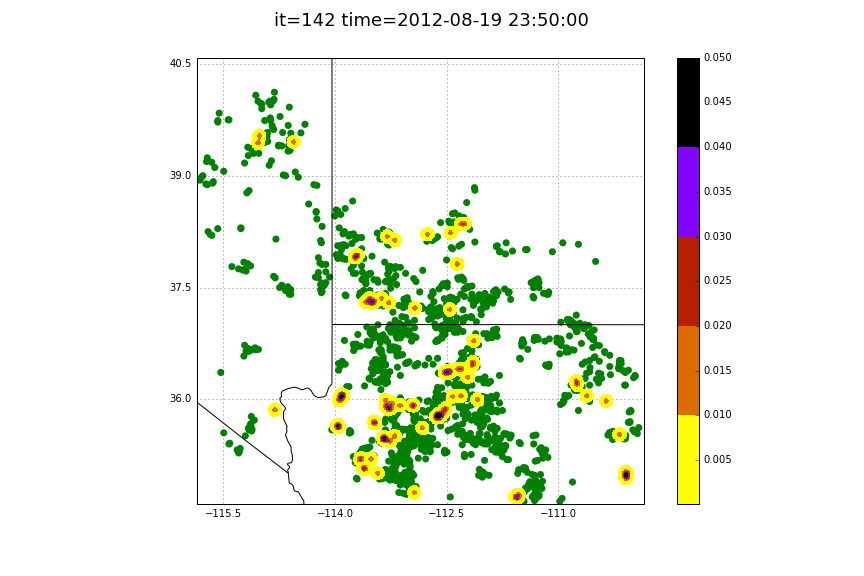
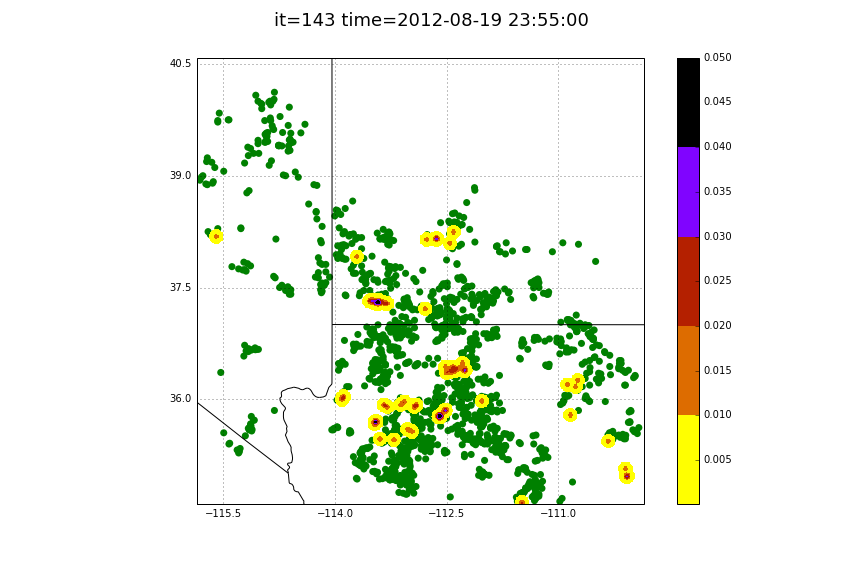
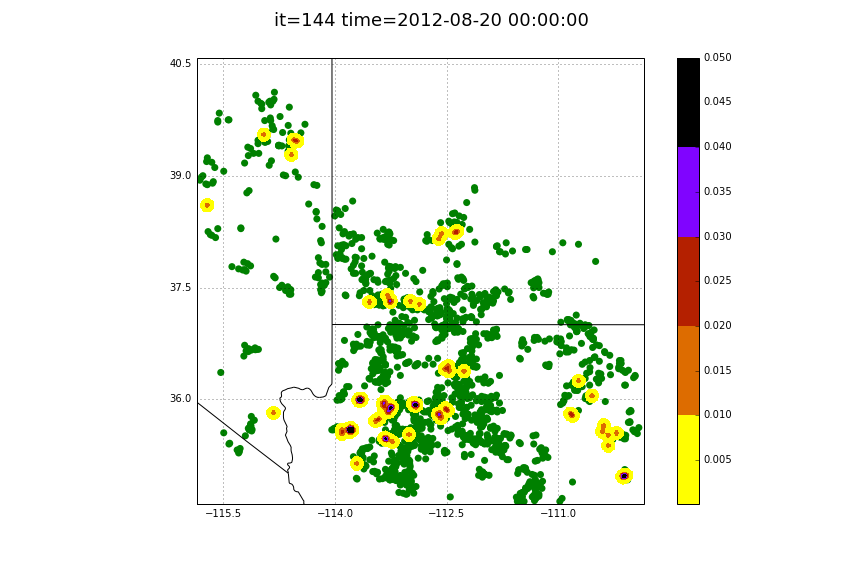
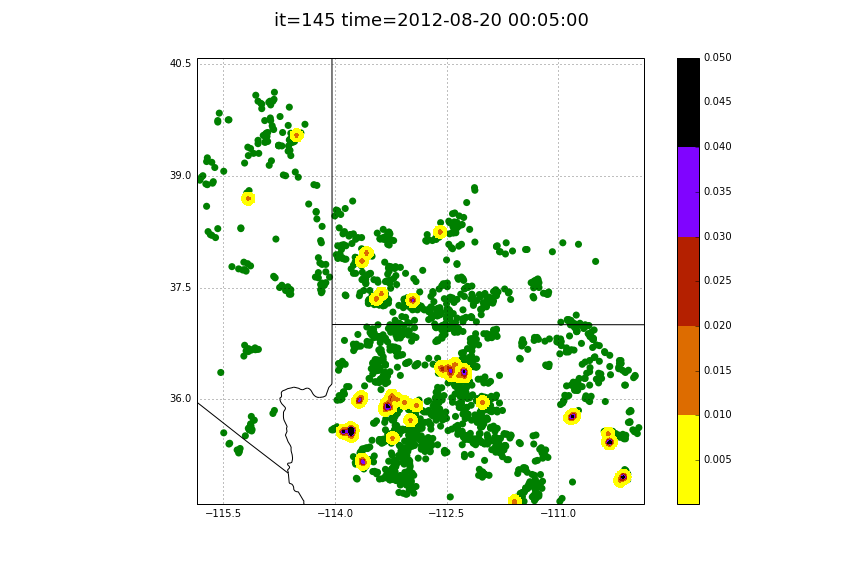
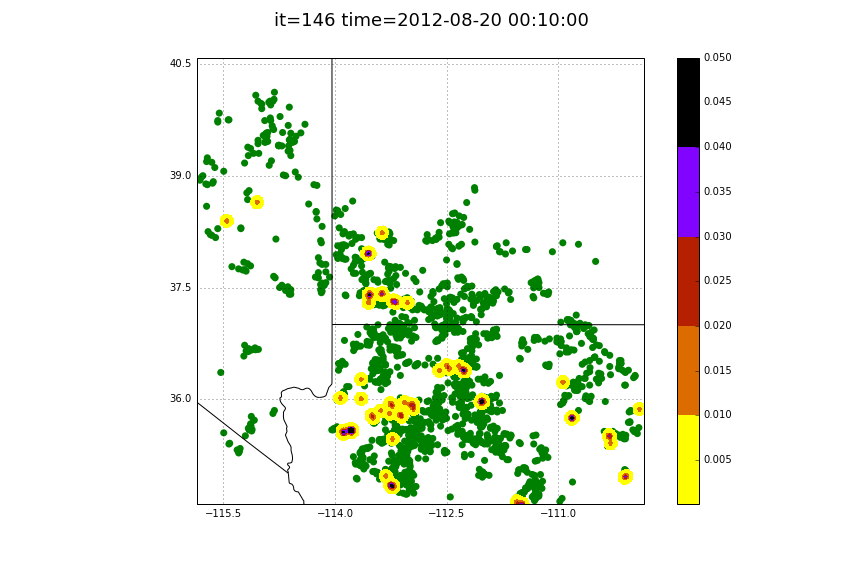
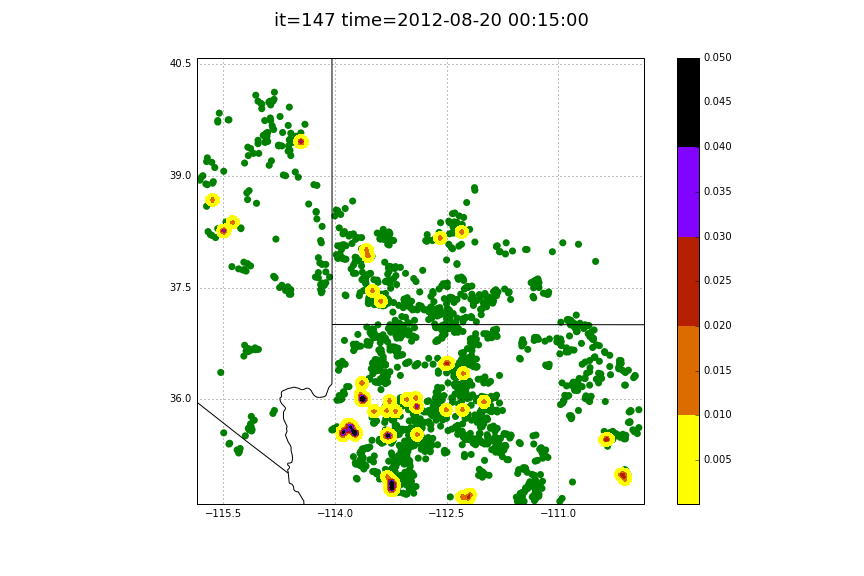
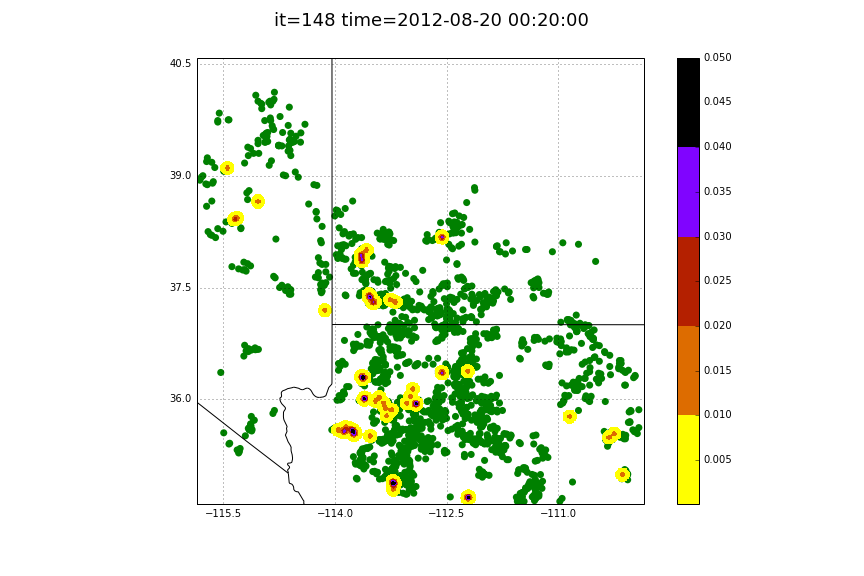
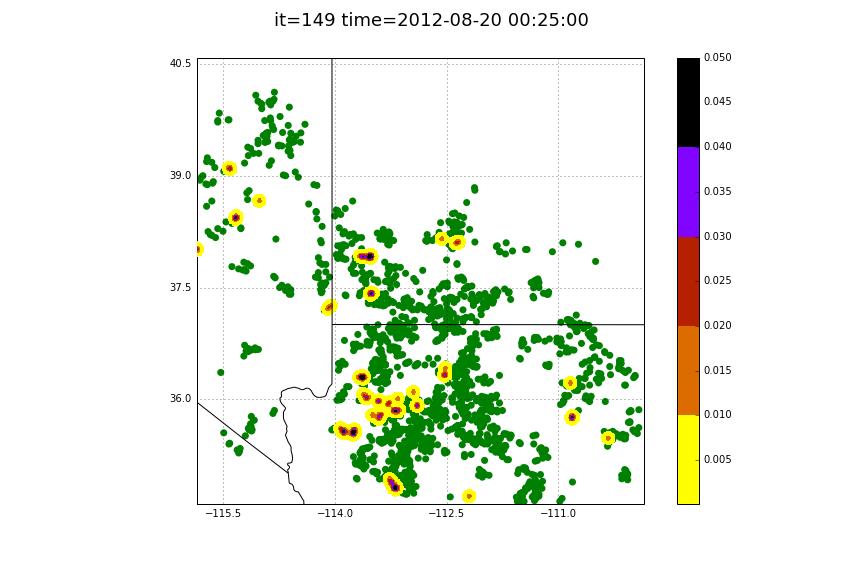
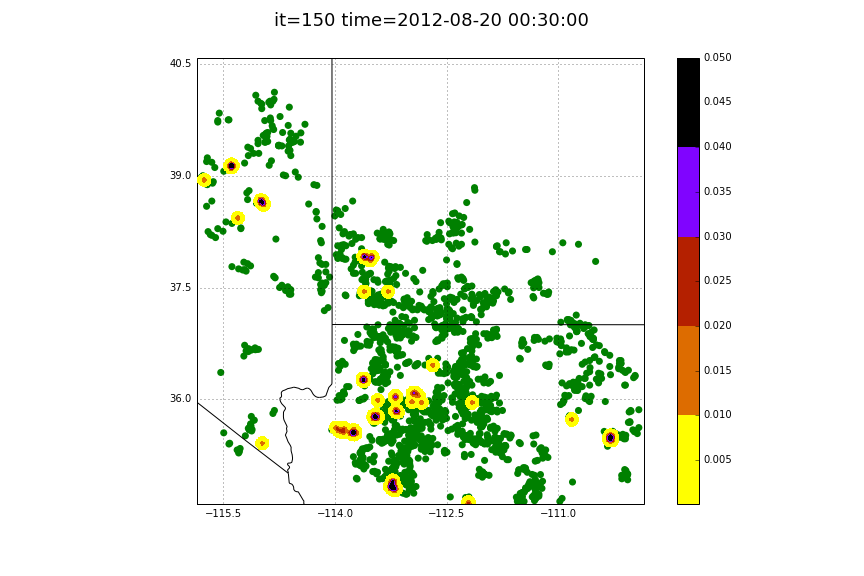
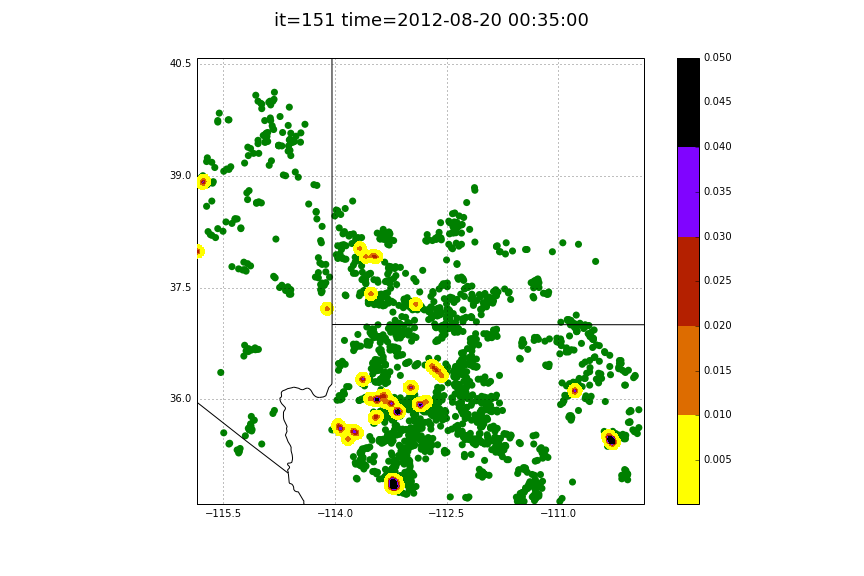
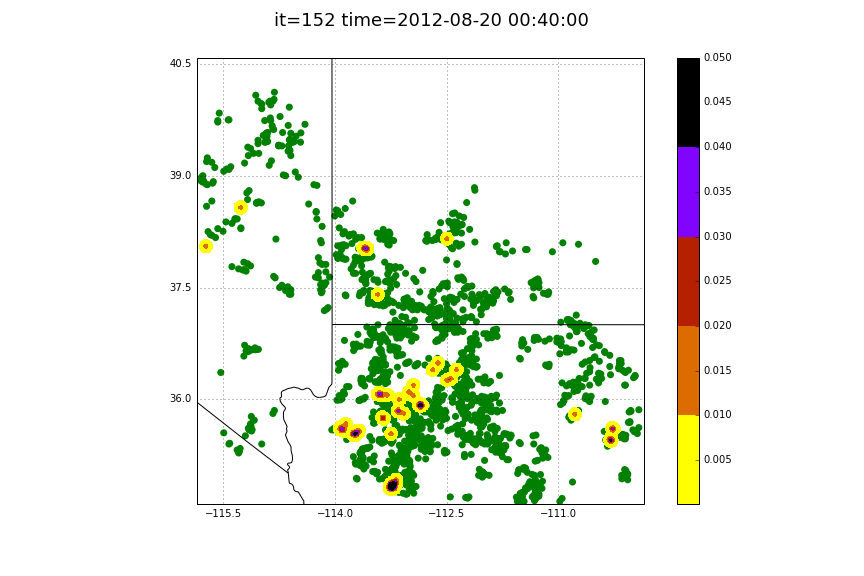
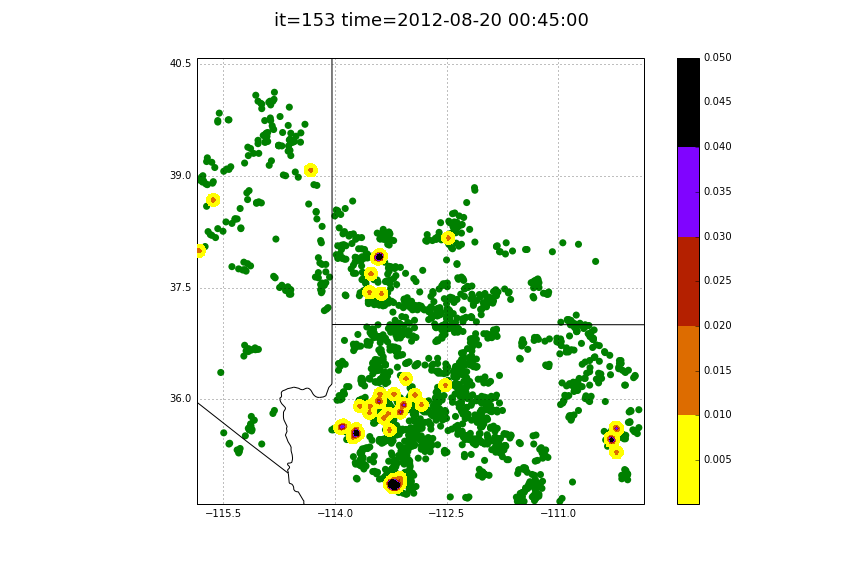
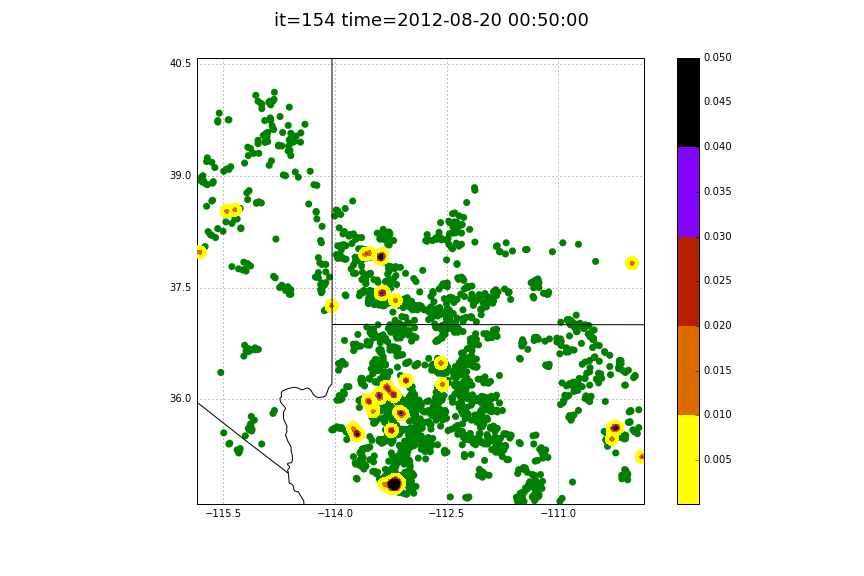
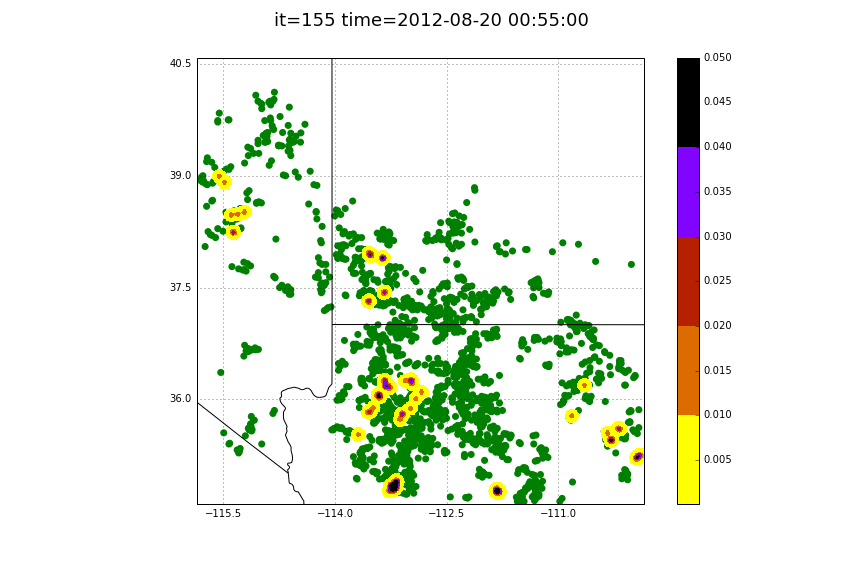
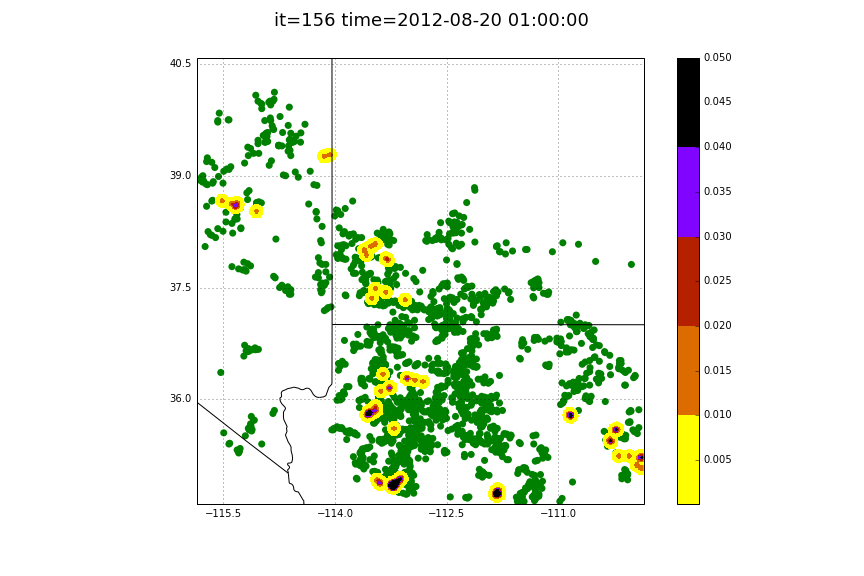
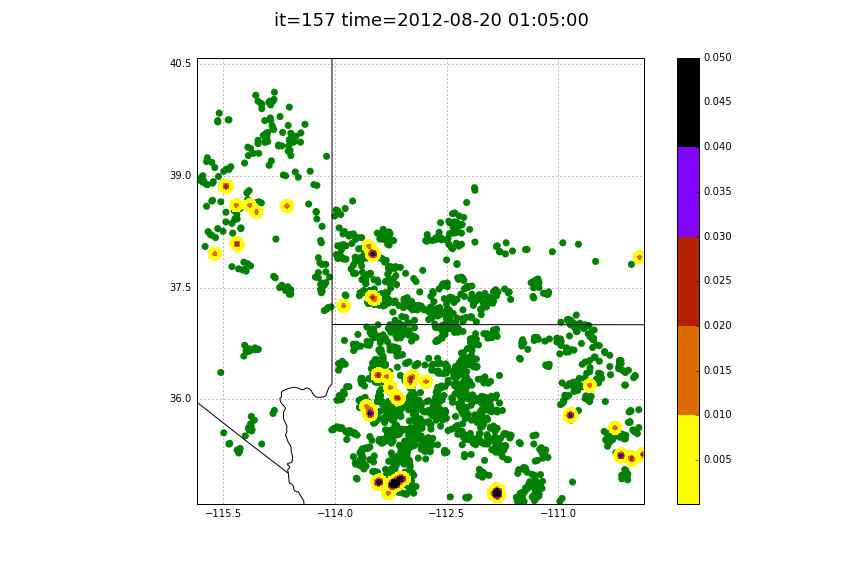
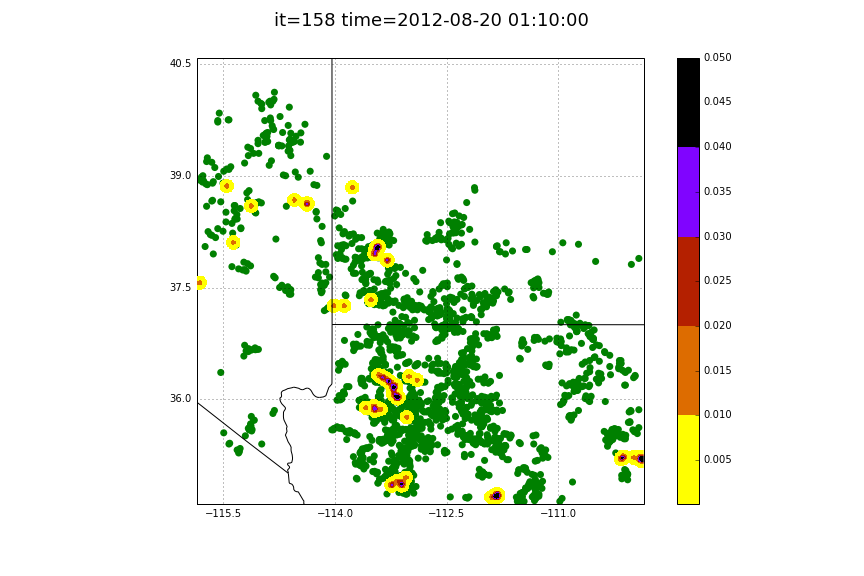
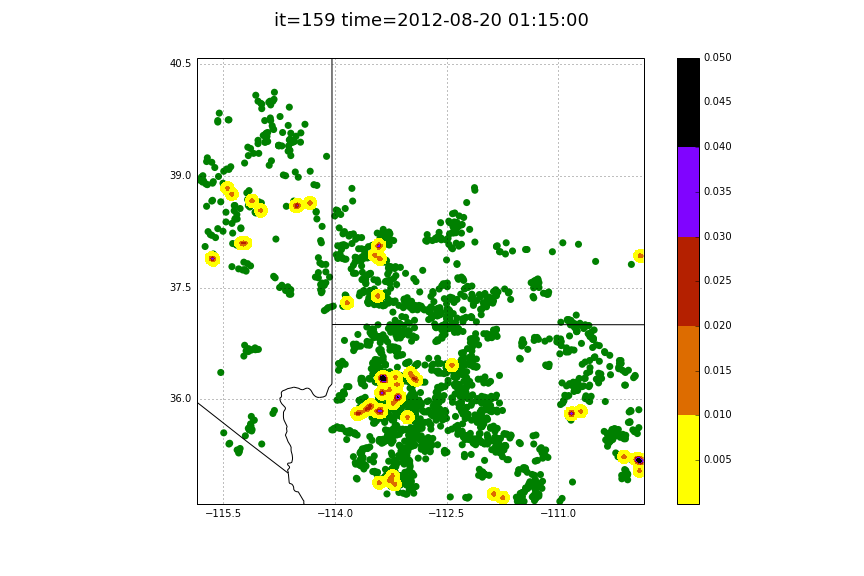
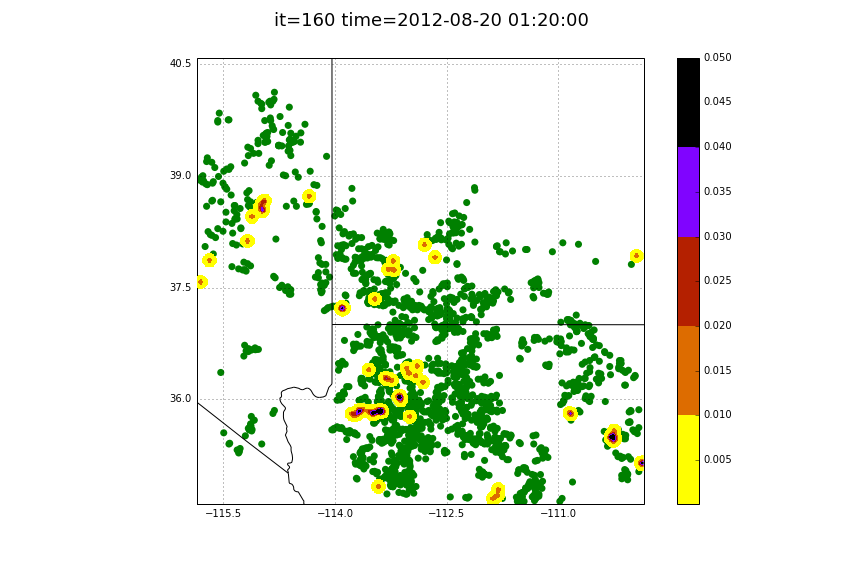
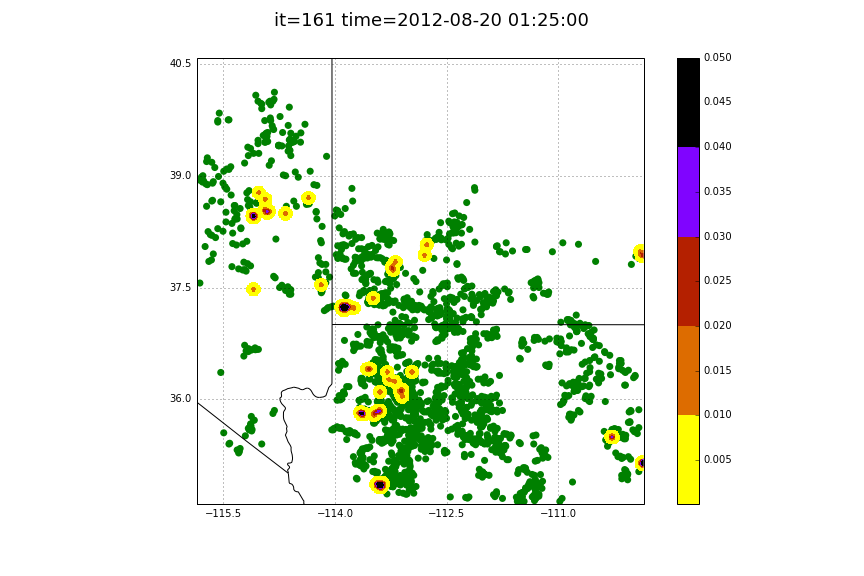
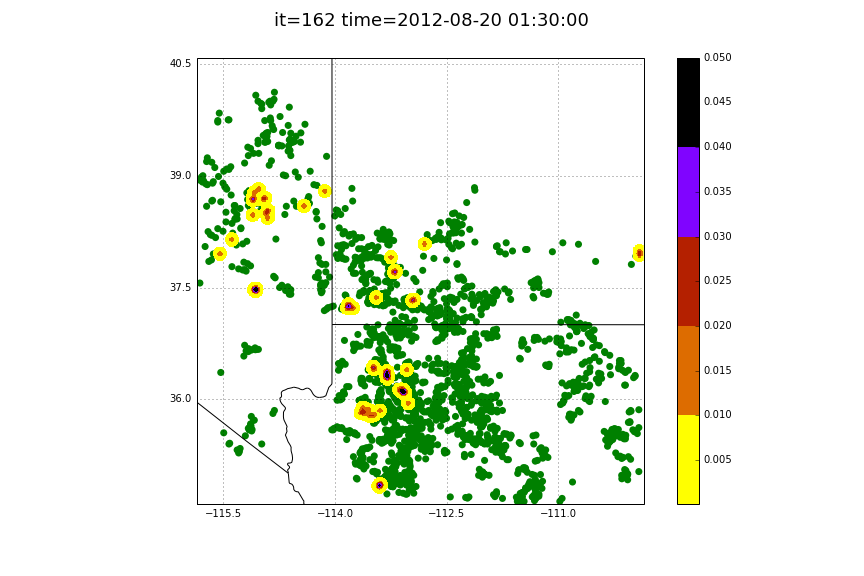
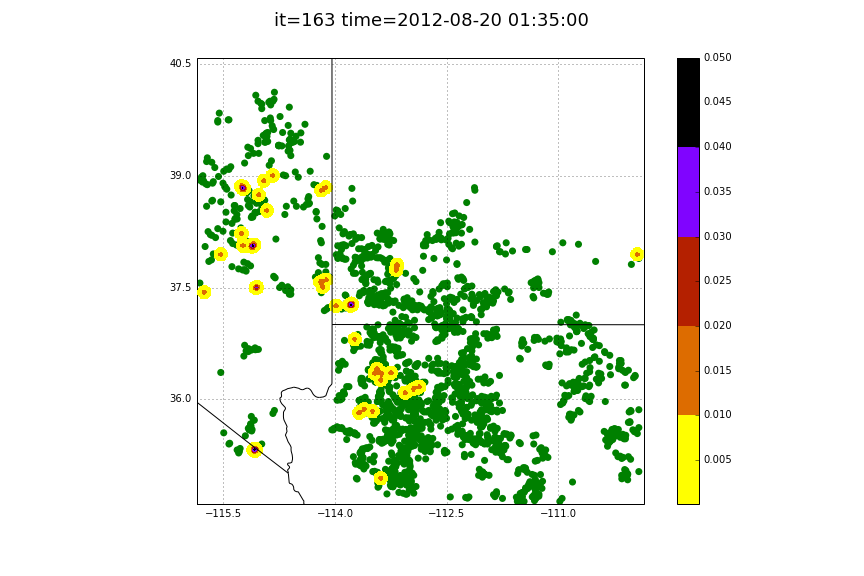
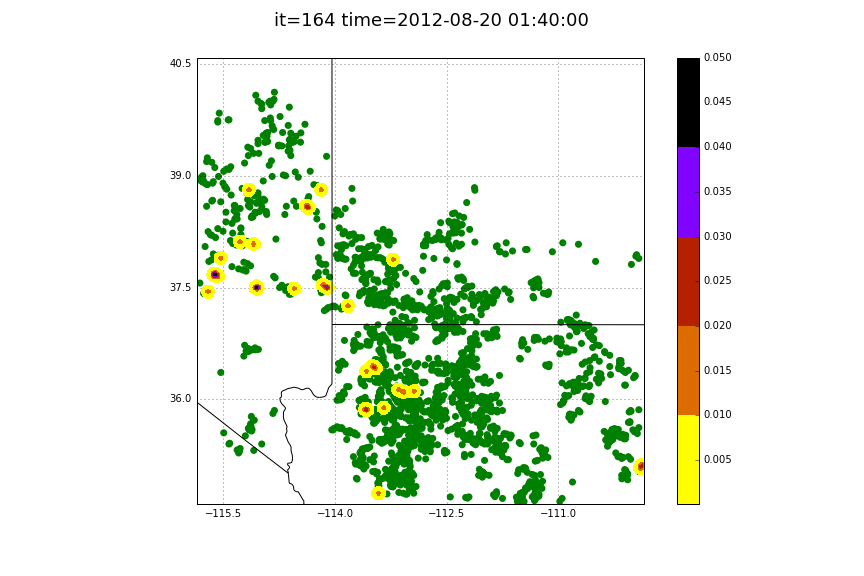
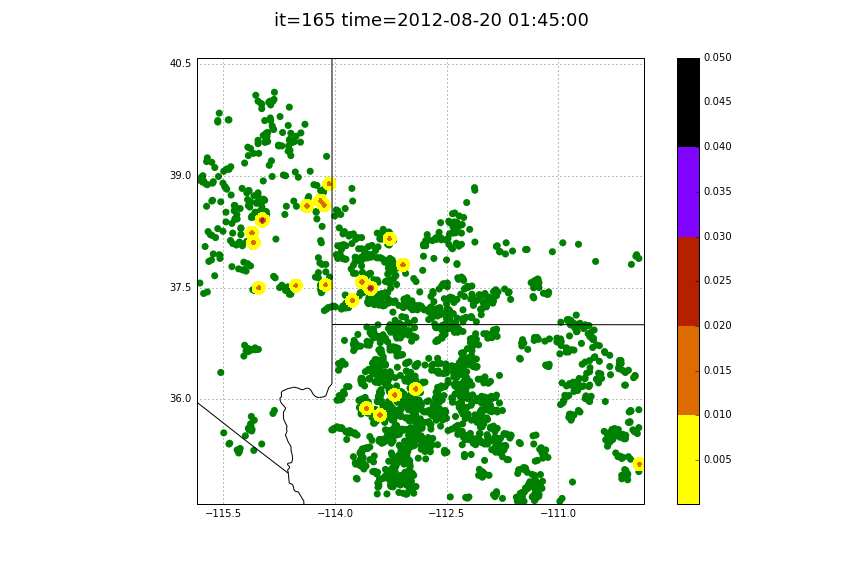
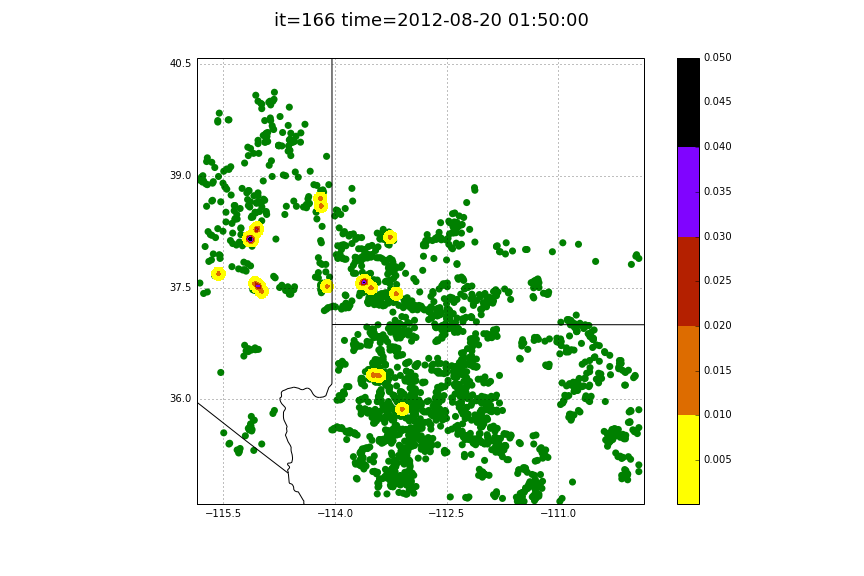
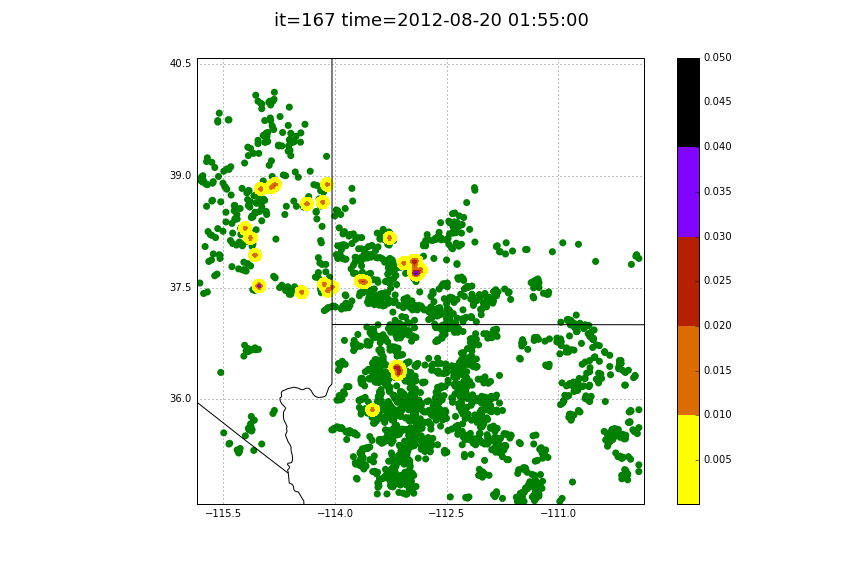
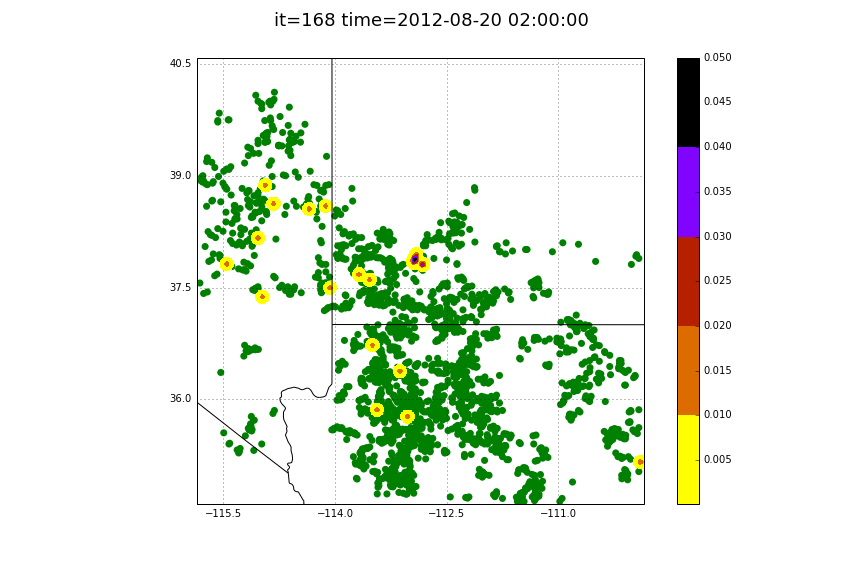
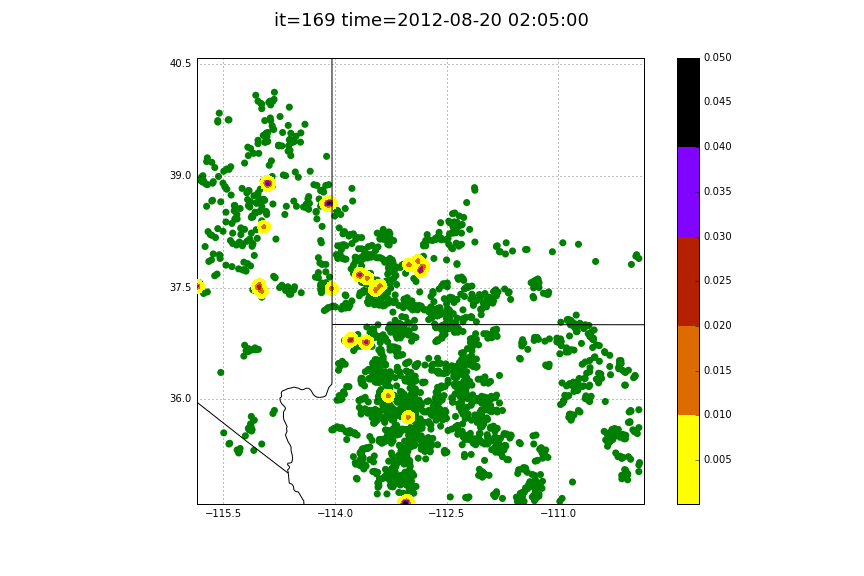
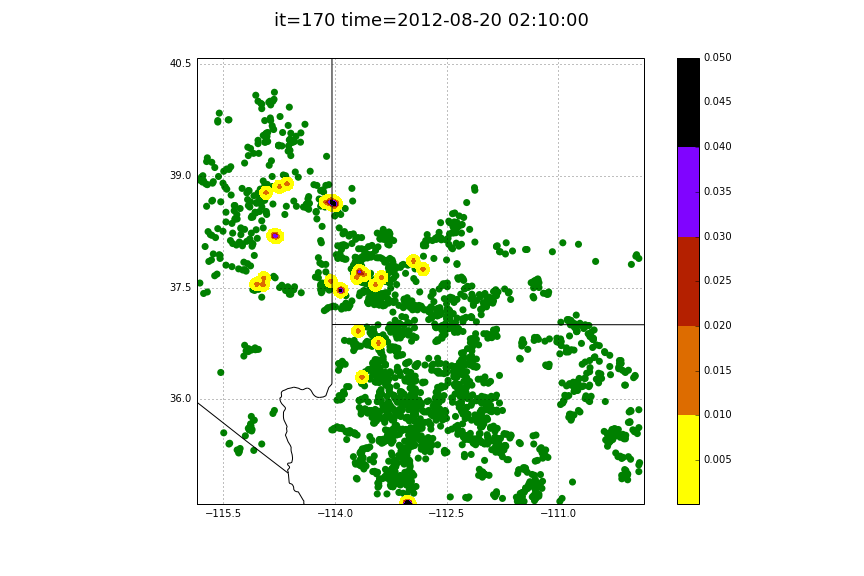
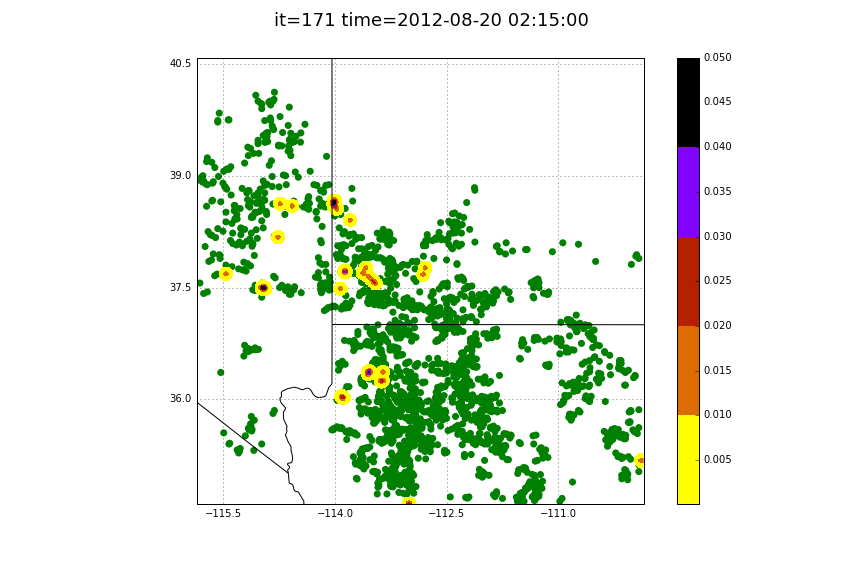

In [26]:
from scipy.ndimage.filters import gaussian_filter
from matplotlib import animation
from JSAnimation import IPython_display

cmap = cmap=plt.get_cmap('gnuplot_r', 5)
cmap.set_under('None')
gauss2d = np.array([gaussian_filter(box[i,:,:], 3) for i in range(box.shape[0])])

it0 = 72
by = 1
fig = plt.figure(figsize=(12, 8))

ax2 = background(plt.subplot(1, 1, 1, projection=ccrs.PlateCarree()))
im2, ax2 = c.plot_grid(gauss2d[it0], vmin=0.0001, vmax=.05, cmap=cmap, cbar=True, ax=ax2)

def init():
    im2.set_data(gauss2d[it0])
    return im2, 

def animate(i):
    im2.set_data(gauss2d[it0+i*by])
    try:
        ax2.scatter(p[tr[it0+i*by],:,'centroidX'],p[tr[it0+i*by],:,'centroidY'], 
                    c='green', edgecolors='None', s=50)
    except:
        pass
    fig.suptitle("it={i} time={t}".format(i=it0+i*by, t=tr[it0+i*by]), fontsize=18)
    return im2,  

animation.FuncAnimation(fig, animate, init_func=init, blit=True, frames=100, interval=100)

## Explanation of tracking done by point process

 - Storm event CG flash density fields at ~.25 km grid resolution and 5 minute time resolution.  2D Gaussian distribution of each CG flash.  
 - Storm tracking for CG flash density fields. 

The first step is making these ~1km 5min grid slices. We will be using just one day of data for these and we already know the top days so we will look at that one first. 

In [2]:
c = Region(city=cities['cedar'])
c.get_top(10)

2014-09-26 12:00:00    91884
2014-09-27 12:00:00    90627
2015-08-30 12:00:00    66916
2014-08-12 12:00:00    65613
2015-07-08 12:00:00    63068
2015-07-01 12:00:00    62599
2013-08-17 12:00:00    62191
2014-08-26 12:00:00    58833
2014-07-15 12:00:00    50065
2015-08-07 12:00:00    48051
dtype: int64

For the first step we will take the whole area at 10km grid cell size and flatten the data along the various axes to see whether there are any that we can get rid of.

In [4]:
c.define_grid(60)
box, tr = c.get_daily_grid_slices('2014-09-26')

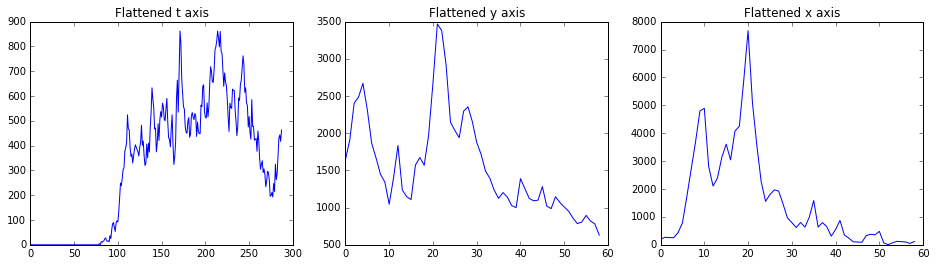

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

axes[0].plot(np.sum(box, axis=(1,2)))
axes[0].set_title("Flattened t axis");

axes[1].plot(np.sum(box, axis=(0,2)))
axes[1].set_title("Flattened y axis")

axes[2].plot(np.sum(box, axis=(0,1)))
axes[2].set_title("Flattened x axis");

From these flattened shadows of the storm, we can select out the most interesting part of the grid and pump up the resolution. 

In [216]:
c.define_grid(nbins=200, extents=[c.gridx[5], c.gridx[25], c.gridy[15], c.gridy[35]])
box, tr = c.get_grid_slices('2014-09-26', freq='5min')
box = box[100:250,:,:]
tr = tr[100:250]

## Tracking features

In [8]:
from rpy2 import robjects 
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
SpatialVx = importr('SpatialVx')
rsummary = robjects.r.summary

In [55]:
def import_r_tools(filename='r-tools.R'):
    import os
    from rpy2.robjects import pandas2ri, r, globalenv
    from rpy2.robjects.packages import STAP
    pandas2ri.activate()
    #path = os.path.dirname(os.path.realpath(__file__))
    path = './'
    with open(os.path.join(path,filename), 'r') as f:
        string = f.read()
    rfuncs = STAP(string, "rfuncs")
    return rfuncs

def dotvars(**kwargs):
    res = {}
    for k, v in kwargs.items():
        res[k.replace('_', '.')] = v
    return res

In [121]:
r_tools = import_r_tools()

In [190]:
d = {}
X, Y = np.meshgrid(c.gridx[0:-1], c.gridy[0:-1])
ll = np.array([X.flatten('F'), Y.flatten('F')]).T
for i in range(box.shape[0]-1):
    hold = SpatialVx.make_SpatialVx(box[i,:,:], box[i+1,:,:], loc=ll)
    look = r_tools.FeatureFinder_gaussian(hold, smoothpar=3,nx=199, ny=199, thresh=.01, **(dotvars(min_size=4)))
    try:
        x = rsummary(look, silent=True)[0]
    except:
        continue
    px = pandas2ri.ri2py(x)
    df0 = pd.DataFrame(px, columns=['centroidX', 'centroidY', 'area', 'OrientationAngle', 
                                  'AspectRatio', 'Intensity0.25', 'Intensity0.9'])
    df0['Observed'] = list(df0.index+1)
    m = SpatialVx.centmatch(look, criteria=3, const=5)
    p = pandas2ri.ri2py(m[12])
    df1 = pd.DataFrame(p, columns=['Forecast', 'Observed'])
    l = SpatialVx.FeatureMatchAnalyzer(m)
    try:
        p = pandas2ri.ri2py(rsummary(l, silent=True))
    except:
        continue
    df2 = pd.DataFrame(p, columns=['Partial Hausdorff Distance','Mean Error Distance','Mean Square Error Distance',
                                  'Pratts Figure of Merit','Minimum Separation Distance', 'Centroid Distance',
                                  'Angle Difference','Area Ratio','Intersection Area','Bearing', 'Baddeleys Delta Metric',
                                  'Hausdorff Distance'])
    df3 = df1.join(df2)

    d.update({tr[i]: pd.merge(df0, df3, how='outer')})
p =pd.Panel(d)

[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"


In [257]:
p =pd.Panel(d)
p

<class 'pandas.core.panel.Panel'>
Dimensions: 137 (items) x 18 (major_axis) x 21 (minor_axis)
Items axis: 2014-09-26 20:20:00 to 2014-09-27 08:40:00
Major_axis axis: 0 to 17
Minor_axis axis: centroidX to Hausdorff Distance